# Práctica 3 - Reducción de Dimensionalidades y Clustering

En esta tercera práctica la tarea se basa en torno a un dataset real de la web de *dating* "OkCupid". Debido a que no contamos con una *ground truth* que indique la solución correcta, ni una clasificación que realizar o una regresión que se ajuste a los datos, el objetivo se centrará más en la búsqueda de tendencias (*trends*), comunidades, etc... a fin de lograr encontrar los potenciales matches de cada usuario. Para ello, habrá que emplear modelos matemáticos vistos en clase especializados para cada tipo de datos.

Utilizaremos la métrica $silhouette$ para tener una idea de cuán "buenos" han sido los descubrimientos y operaciones realizadas sobre los datos.

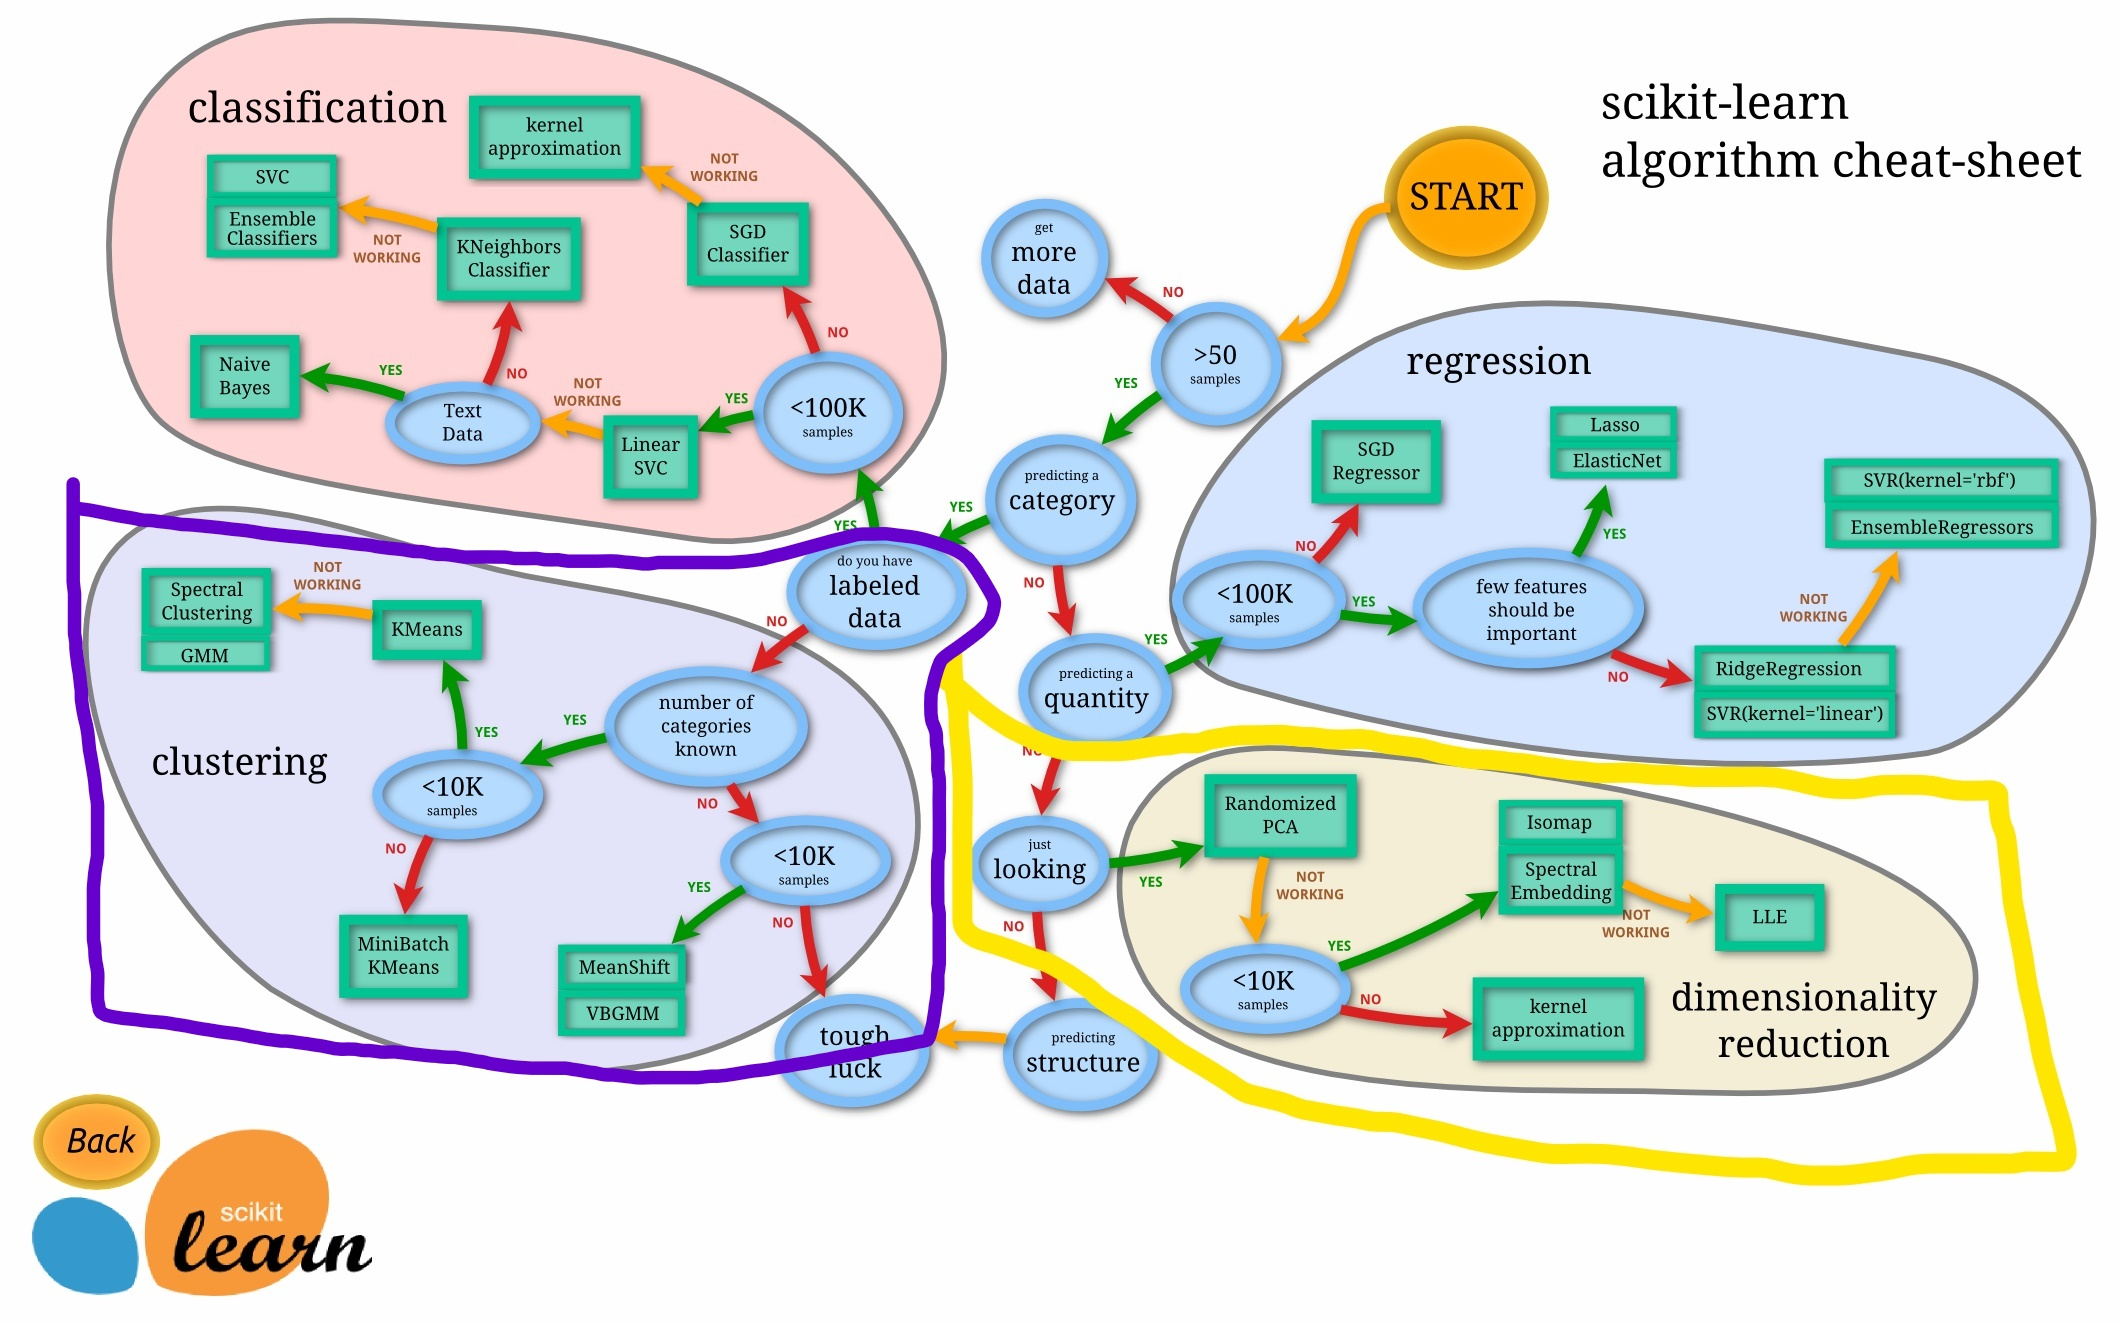

Nos centraremos en la zona resaltada en amarillo de la figura, correspondiente a "dimensionality reduction", y la morada, "clustering".

---
## Conozcamos el propósito, al cliente y a los usuarios finales

### Qué es el dating?
Antes que nada, y a pesar de ser un término ampliamente integrado en el vocabulario común, vamos a explicar qué es y en qué consiste el *dating* para aquellos que no estén familiarizados.

Según [Oxford Languages](https://languages.oup.com/google-dictionary-en/):
>To go out with (someone in whom one is romantically or sexually interested).

En otras palabras, tener citas, salir. En el contexto en el que hablamos, se trata de agencias y/o servicios especializados en encontrar posibles candidatos a ser pareja romántica. OkCupid es uno de estos servicios, que recaba información de sus usuarios y empareja aquellos a quiénes considera afines (el método/algoritmo es secreto empresarial, y por ende tendremos que hacer ingeniería inversa para lograr unos resultados acorde a sus criterios).

### OkCupid frente a otros servicios

Puesto que esta práctica se basa en una compañía real, con una misión, visión, objetivos, intereses, usuarios finales... Lo primero que queremos conocer es a quién van dirigidos estos análisis y algoritmos, saber un poco más de qué diferencia a OkCupid del resto de productos de *dating* del mercado, y qué buscan las personas que hacen uso de este servicio.

Por ello, vamos directamente a la fuente, [la web de OkCupid](https://www.okcupid.com/), en la que se publicitan cosas como:
>On OkCupid, you’re more than just a photo. You have stories to tell, and passions to share, and things to talk about that are more interesting than the weather. Get noticed for who you are, not what you look like. Because you deserve what dating deserves: better.

> At OkCupid, we’re dedicated to helping people find love and happiness through meaningful connections. Our one-of-a-kind algorithm matches you on what actually matters.

>There are some things you should know before the date. On OkCupid, we help you find people you’re really compatible with.

>No matter who you are, no matter what you’re looking for, OkCupid helps you find meaningful connections—whatever that means to you.

De primeras, parece que hacen mucho hincapié en encontrar matches *para ti*, *busques lo que busques*, que sean *meaningful* (con sentido, con valor). Es decir, se distancian de servicios como Tinder o Grindr, que simplifican mucho el proceso a coste de ser extremadamente superficiales, muy a menudo juzgando personas únicamente por su físico, puesto que los usuarios no se ven obligados a describir nada sobre ellos en su perfil.

En OkCupid se valora no sólo el físico, si no también la personalidad de los usuarios, sus hábitos, rasgos característicos... En resumen, buscan un mayor nivel de profundidad de cada individuo que una mera selección de fotos.

Cabe añadir que tampoco es una plataforma dedicada a una comunidad específica, como pueden ser [Cupidtino.com](https://Cupidtino.com), dedicada a *fanboys* y *fangirls* de Apple ([cerrada desde 2015](https://twitter.com/cupidtino/status/573518684838199296?s=20)), o [RepublicanPeopleMeet.com](https://www.republicanpeoplemeet.com/) y [DemocratPeopleMeet.com](https://www.democratpeoplemeet.com/), orientadas a personas de una afiliación política específica. OkCupid está *abierta a todo el mundo*, por tanto los matches deberían reflejar estas condiciones y no segregar en base a posibles identificaciones raciales, étnicas, ideológicas, religiosas... Deberían centrarse únicamente en los intereses comunes, personalidades compatibles y sexualidad preferida, principalmente.

Debido a la naturaleza más intrínseca, detallada y que requiere más tiempo (y por tanto lleva a los usuarios a buscar relaciones más significativas y menos efímeras) asumiremos que su base de usuarios posee una media de edad más elevada que la de Tinder y similares, en torno a los 30-40 años [4][5].

## Enfoque del problema
El enfoque tomado de este análisis es obtener clusters de compatibilidad. Estos clusters permitirán la conexión entre personas con características similares. Así pues, su aplicación sería el emparejamiento entre individuos del mismo cluster (relaciones intra-clusters) en vez de intentar agrupar individuos similares y relacionarlos con los de otros clusters (relaciones inter-cluster).

La idea con la que partimos es la separación de las personas por orientación sexual. Por lo tanto realizaremos el proceso de aprendizaje no supervisado 3 veces: una para personas heterosexuales, otra para hombres homosexuales y una última para mujeres homosexuales. Las personas bisexuales estarán en todos los procesos (tanto hetero como homo de su mismo género).

Dentro de la categoría de heterosexuales, se emparejarán personas de distinto sexo a nivel de aplicación.

---
## Variables globales e imports

In [ ]:
pip install kmodes

In [ ]:
pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68503 sha256=3e931901f62927b40a5fee5b1e894a29004d3520781a8ca977a6e20d8c91335e
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [ ]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer, LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import silhouette_score as silhouette

import gensim
import nltk
import string
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *

#nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

columns = ['age', 'marital_status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'pets', 'religion', 'sign',
       'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4',
       'essay5', 'essay6', 'essay7', 'essay8', 'essay9'] 
seed = 1337
np.random.seed(seed)
random.seed(seed)

pd.options.mode.use_inf_as_na = True
# Treats empty strings, infinite values... as NA

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Carga de Datos

NOTA: Debido a que no se especifica un número de clusters, optaremos por elegir un número aleatorio así como pruebas "a mano" para distintos valores a fin de mostrar diferentes resultados y obtener un rango de posibles alternativas más variado.

Por eficiencia durante los experimentos hemos ido exportando los dataframes a .csv en distintas etapas del preprocesamiento, incluyendo el producto final. Mantenemos el código que sirvió para procesarlos pero recomendamos no ejecutarlas puesto que tarda bastante. Si se desea recrear los experimentos, vaya directamente a la sección **essays y tratamientos de textos**

In [ ]:
!npx degit https://github.com/BoscoDomingo/ML-P3-Clustering/data#main -f 

npx: installed 1 in 3.625s
> destination directory is not empty. Using --force, continuing
> cloned BoscoDomingo/ML-P3-Clustering#main


In [ ]:
df1 = pd.read_csv("okcupid_profiles1.csv", names = columns)
df2 = pd.read_csv("okcupid_profiles2.csv", names = columns)

full_data = df1.iloc[1:].append(df2.iloc[1:], ignore_index=True)
original_essays = full_data.iloc[:,-10:].copy()
original_essays = original_essays.fillna('')
full_data = full_data.iloc[:,:-10].join(pd.read_csv('lda_essays.csv', index_col=False))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
full_data.head()

age marital_status sex orientation  ...        26        27        28        29
0  22         single   m    straight  ...  0.092638  0.035751  0.725040  0.239209
1  35         single   m    straight  ...  0.775101  0.333333  0.333333  0.333333
2  38      available   m    straight  ...  0.749345  0.022174  0.957705  0.020121
3  23         single   m    straight  ...  0.333333  0.112387  0.112946  0.774667
4  29         single   m    straight  ...  0.333333  0.333333  0.333333  0.333333

[5 rows x 51 columns]

## Análisis inicial

Debido a que todos los algoritmos de clustering requieren calcular algún tipo de distancia, y no todos permiten usar distintas formas de calcularlas, tenemos que tratar los textos de tal forma que se puedan calcular dichas distancias, proceso conocido como *feature extraction*.

Para todas las columnas aparte de las numéricas y las *essays* usaremos $One-Hot-Encoder$ (y cualquier otro proceso que creamos puede mejorar el rendimiento o la facilidad para encontrar grupos), y para las *essays*, emplearemos *lemmatisation* para obtener las raíces de las palabras, así como eliminar *stop-words* que no aporten información relevante. Una vez hecho eso, aplicaremos $tf-idf$ a fin de obtener los valores numéricos basados en cuán importante es una palabra.

Eliminamos las siguientes columnas puesto que no aportan gran valor real a la hora de emparejar personas.

**Diet**: La dieta no es un factor que afecte a la hora de juntar a 2 personas. Aporta muy poco valor.

**Last online**: La última fecha de conexión no tiene relación ninguna con el emparejamiento y gustos de las personas.

**Height**: No se ha tenido en cuenta la altura puesto que a pesar de que hay gente a la que le pueda influenciar este dato, al no aportarse valor real de cuán importante es la altura para esa persona, hemos decidido quitarlo.

**Ethnicity**: Consideramos que esta aplicación es una buena oportunidad para tratar a todos por igual, sin importar la raza.

**Marital Status**: El objetivo de esta aplicación es relacionarte de manera "amorosa" con otras personas, por lo tanto, este dato es redundante.  

In [ ]:
full_data.drop(columns=['diet', 'last_online', 'height', 'ethnicity', 'marital_status'],inplace=True)

In [ ]:
full_data.iloc[:,:-30].infer_objects().dtypes

age            object
sex            object
orientation    object
body_type      object
drinks         object
drugs          object
education      object
income         object
job            object
location       object
offspring      object
pets           object
religion       object
sign           object
smokes         object
speaks         object
dtype: object

In [ ]:
full_data.iloc[:,:-30] = full_data.iloc[:,:-30].convert_dtypes()
full_data.iloc[:,:-30].dtypes

age            object
sex            string
orientation    string
body_type      string
drinks         string
drugs          string
education      string
income         object
job            string
location       string
offspring      string
pets           string
religion       string
sign           string
smokes         string
speaks         string
dtype: object

### Columnas numéricas

De primeras se observa que los tipos de datos no son los correctos tras la primera conversión automática para las columnas numéricas (por ejemplo, `income`), y por ende esa será la siguiente transformación a realizar. 

In [ ]:
full_data[["age", "income"]] = full_data[["age", "income"]].apply(pd.to_numeric)

Visto que los valores numéricos eran los que parecen presentar mayores problemas de tipo de datos (algunos estaban como números, otros como strings) muy probablemente haya también valores falsos, o errores en el procesamiento.

#### `age`

In [ ]:
full_data.age.describe()

count    59946.000000
mean        32.340290
std          9.452779
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max        110.000000
Name: age, dtype: float64

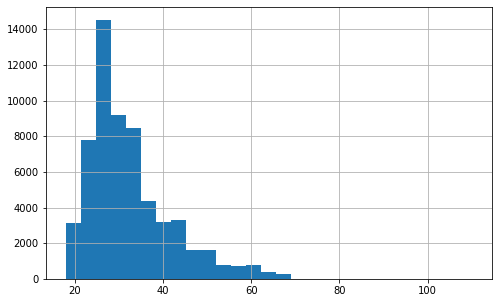

In [ ]:
full_data.age.hist(figsize=(8,5), bins=int(full_data.age.nunique()/2))

Nos damos cuenta de que casi todos los datos están por debajo de los 70 años.

In [ ]:
full_data[full_data['age'] > 80]

age sex orientation body_type  ...        26        27        28        29
2512   110   f    straight      <NA>  ...  0.333333  0.333333  0.333333  0.333333
25324  109   m    straight  athletic  ...  0.333333  0.333333  0.333333  0.333333

[2 rows x 46 columns]

Como mencionamos previamente, en efecto la media de edad de los datos ronda los 32 años, aunque ciertamente esperábamos que fuese ligeramente mayor. Puede deberse a que la fecha de la toma de estos datos es 2012 mientras que los estudios referenciados son posteriores, y que han pasado más de 8 años desde entonces.

Observamos además 2 valores anómalos, que podemos asumir son perfiles falsos puesto que dudamos que personas de 109 y 110 años estén buscando pareja en OkCupid.

Aplicamos también una conversión de NaN a 18, asumiendo que al usar este servicio son, como mínimo, mayores de edad.

In [ ]:
full_data['age'] = full_data['age'].replace(np.nan, 18)
full_data = full_data[full_data['age'] < 80].reset_index(drop=True)

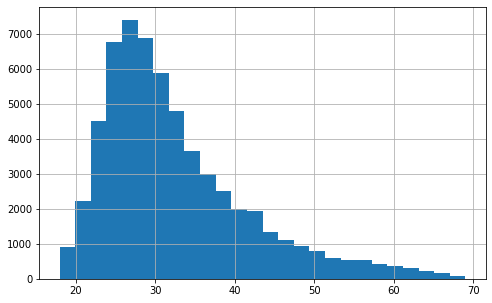

In [ ]:
full_data.age.hist(figsize=(8,5), bins=int(full_data.age.nunique()/2))

#### `income`

In [ ]:
full_data.income.describe()

count      59944.000000
mean       20033.890965
std        97347.747284
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           -1.000000
max      1000000.000000
Name: income, dtype: float64

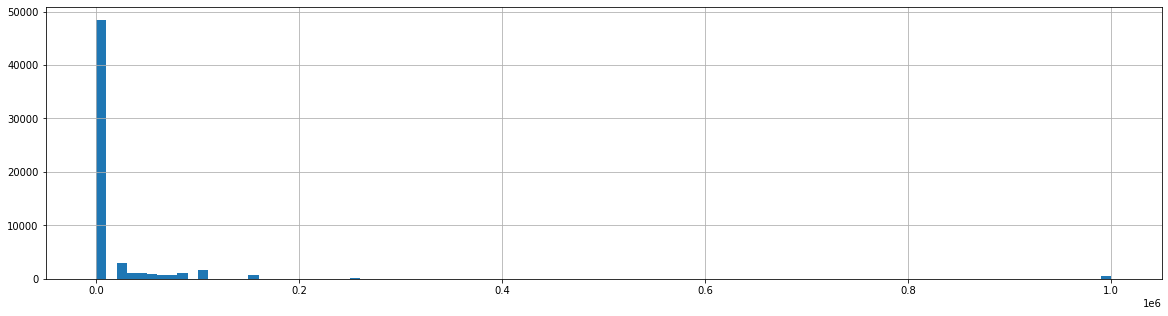

In [ ]:
full_data.income.hist(figsize=(20,5),bins=100)

Observamos que mucha gente no quiso incluir su salario en el perfil, por ende la media salarial estará sesgada hacia abajo debido a que dicha ausencia se marca con -1. Para visualizar mejor los datos, sustituimos los -1 por NaN.

In [ ]:
df_income_no_nans = full_data.income.apply(lambda x: x if x>= 0 else np.nan)

In [ ]:
df_income_no_nans.describe()

count      11504.000000
mean      104394.993046
std       201433.528307
min        20000.000000
25%        20000.000000
50%        50000.000000
75%       100000.000000
max      1000000.000000
Name: income, dtype: float64

In [ ]:
df_income_no_nans.value_counts()

20000.0      2952
100000.0     1621
80000.0      1111
30000.0      1048
40000.0      1005
50000.0       975
60000.0       736
70000.0       707
150000.0      631
1000000.0     521
250000.0      149
500000.0       48
Name: income, dtype: int64

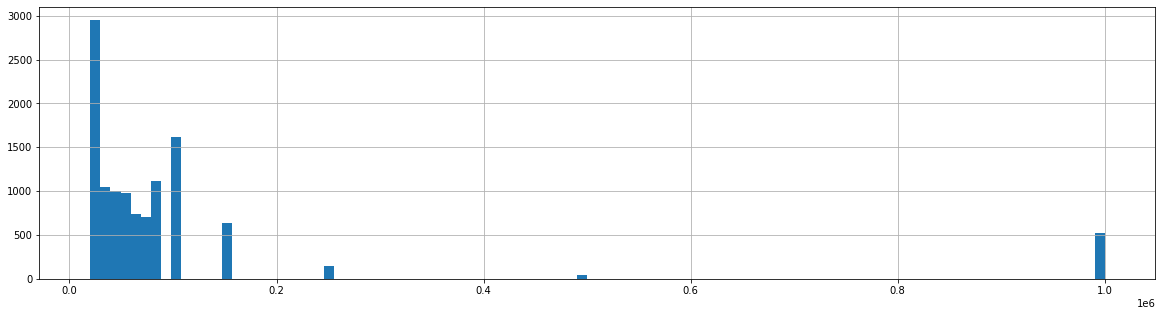

In [ ]:
df_income_no_nans.hist(figsize=(20,5),bins=100)

Se observa una disparidad importante en los salarios, donde la mayoría se concentran en el extremo "bajo" (inferior a los \$200K), pero una cantidad significativa de usuarios reporta un salario de $1M o más.

###Columnas categóricas

Pasamos a analizar las columnas categóricas:

In [ ]:
categorical_columns = ['sex', 'orientation', 'body_type', 'drinks',
       'drugs', 'education',  'job', 'location', 'offspring', 
       'pets', 'religion', 'sign', 'smokes', 'speaks']
for column in categorical_columns:
    print(column,"\n", full_data[column].unique(), "\n\n")

sex 
 <StringArray>
['m', 'f']
Length: 2, dtype: string 


orientation 
 <StringArray>
['straight', 'bisexual', 'gay']
Length: 3, dtype: string 


body_type 
 <StringArray>
['a little extra',        'average',           'thin',       'athletic',
            'fit',             <NA>,         'skinny',          'curvy',
   'full figured',         'jacked', 'rather not say',        'used up',
     'overweight']
Length: 13, dtype: string 


drinks 
 <StringArray>
['socially', 'often', 'not at all', 'rarely', <NA>, 'very often',
 'desperately']
Length: 7, dtype: string 


drugs 
 <StringArray>
['never', 'sometimes', <NA>, 'often']
Length: 4, dtype: string 


education 
 <StringArray>
[    'working on college/university',             'working on space camp',
    'graduated from masters program', 'graduated from college/university',
       'working on two-year college',                                <NA>,
        'graduated from high school',        'working on masters program',
         'gra

* Para todas remplazaremos las columnas con '\<NA>' o 'unknown' por un valor neutro o vacío a fin de ser más fácil de tratar posteriormente.


* Para `body type` crearemos un label encoder de manera manual, asignando valores entre 0 y 4 dependiendo del tipo de cuerpo. El estudio que hemos hecho es subjetivo, pero es el que más correcto nos ha parecido en cuanto a similitud de cuerpos

* Para `drink`, `drugs` y `smokes` crearemos un label encoder manual en base a la frecuencia de consumo.

* Para `education` y `job` crearemos un label encoder de manera manual, asignando valores en un rango dependiendo del tipo de educación (cuanto más educación haya recibido, mayor será su valor) o, del tipo de trabajo, en cuyo caso hemos realizado un rango en base al tipo de trabajo y las habilidades que requiere cada uno de ellos. 

* Para `offspring` lo vamos a romper en 2 columnas (*Label Encoder*): `has kids` y `wants kids`. Ambas irán de 0 a 2. La primera con 0 (no tiene o no ha dicho nada), 1 (tiene 1), 2 (>1 hijo). La segunda con 0 (unknown o no quiere), 1 (puede que quiera), 2 (seguro que quiere).

* Para `pets` lo vamos a romper en 4 columnas (*Label Encoder*): `likes dogs`, `likes cats`, `has dogs`, `has cats`. La columna de `like`, irán entre 0 y 2, siendo 0 no me gusta y 2 me gusta, y la columna `has` indicará el número de animales.

* Para `sign` y `religion`, se creará una nueva columna con la importancia que le da la persona a esa característica. Estas 2 columnas serán tratadas posteriormente como OHE u otro formato para realizar el clustering.

* Para `location` cogeremos ", " y haremos un split, quedándonos con la última parte, que corresponde al estado (si son de USA) o al país. Posteriormente, obtendremos la longitud y latitud para poder realizar un mapa en 2 dimensiones que represente una distancia real entre los usuarios.

* Para `speaks` crearemos un OHE siendo los valores de cada columna el nivel del idioma entre 0 (nulo) o 3 (domina el idioma). 


#### Sustituciones

#####`body type`, `drink`, `drugs` y `smokes`

Aplicamos un $Label Encoder$ a las columnas `body type`, `drink`, `drugs` y `smokes` en base a lo que consideramos se asemeja o diferencia más dentro de cada una.

In [ ]:
# Body Type
full_data.body_type = full_data.body_type.replace(np.nan, "rather not say")
full_data.body_type = full_data.body_type.apply(lambda x: 0 if x in ['skinny','thin'] else 1 if x in ['athletic','fit','jacked'] else 2 if x in ['average','rather not say'] else 3 if x in ['curvy','full figured'] else 4)

# Drink
full_data.drinks = full_data.drinks.replace(np.nan, 'not at all')
full_data.drinks = full_data.drinks.apply(lambda x: 0 if x=='not at all' else 1 if x=='rarely' else 2 if x=='socially' else 3 if x=='often' else 4)

# Drugs
full_data.drugs = full_data.drugs.replace(np.nan, 'never')
full_data.drugs = full_data.drugs.apply(lambda x: 0 if (x==np.nan or x=='never') else 1 if x=='sometimes' else 2)

# Smokes
full_data.smokes = full_data.smokes.replace(np.nan, 'no')
full_data.smokes = full_data.smokes.apply(lambda x: 0 if (x==np.nan or x=='no') else 2 if x=='yes' else 1)

##### `education` y `job`

Para `education` y `job`, haremos una escala en cuanto al tipo de estudios o trabajo que se realice. 

In [ ]:
full_data.education.unique()

<StringArray>
[    'working on college/university',             'working on space camp',
    'graduated from masters program', 'graduated from college/university',
       'working on two-year college',                                <NA>,
        'graduated from high school',        'working on masters program',
         'graduated from space camp',                'college/university',
         'dropped out of space camp',       'graduated from ph.d program',
         'graduated from law school',           'working on ph.d program',
                  'two-year college',   'graduated from two-year college',
             'working on med school', 'dropped out of college/university',
                        'space camp',         'graduated from med school',
        'dropped out of high school',            'working on high school',
                   'masters program',       'dropped out of ph.d program',
   'dropped out of two-year college',         'dropped out of med school',
           

In [ ]:
full_data.job.unique()

<StringArray>
[                   'transportation',              'hospitality / travel',
                                <NA>,                           'student',
       'artistic / musical / writer',    'computer / hardware / software',
 'banking / financial / real estate',             'entertainment / media',
       'sales / marketing / biz dev',                             'other',
                 'medicine / health',      'science / tech / engineering',
            'executive / management',              'education / academia',
         'clerical / administrative',      'construction / craftsmanship',
                    'rather not say',            'political / government',
              'law / legal services',                        'unemployed',
                          'military',                           'retired']
Length: 22, dtype: string

In [ ]:
# Education
full_data['education'] = full_data['education'].replace(np.nan, 'rather not say')
full_data['education'] = full_data['education'].apply(lambda x: 0 if x in ['dropped out of high school'] else 1 if x in['working on high school','high school','rather not say','graduated from high school','dropped out of college/university','dropped out of law school','dropped out of masters program','dropped out of med school','dropped out of ph.d program','dropped out of space camp','dropped out of two-year college'] else 2 if x in ['working on college/university','working on law school','working on masters program','working on med school','working on ph.d program','working on space camp','working on two-year college'] else 3)

# Job
full_data['job'] = full_data['job'].replace(np.nan, 'rather not say')
full_data['job'] = full_data['job'].apply(lambda x: 0 if x in ['rather not say','other','unemployed','retired'] else 1 if x in ['transportation','construction / craftsmanship','military','student'] else 2 if x in ['artistic / musical / writer','entertainment / media','hospitality / travel','education / academia'] else 4 if x in ['computer / hardware / software', 'science / tech / engineering','medicine / health'] else 3)

##### `offspring`

Para offspring, separaremos en tiene hijos o quiere hijos

In [ ]:
def offspring_label_encoder(offspring_list):
    if len(offspring_list) == 0:
        return [0,0]
    want_quantity = 0
    kids_quantity = 0
    if len(offspring_list) == 1:
        if any(w in offspring_list[0] for w in ["have", "has"]):
            kids_quantity = 0 if "doesn't" in offspring_list[0] else 2 if "kids" in offspring_list[0] else 1
            return [kids_quantity,0]
        if any(w in offspring_list[0] for w in ["want", "wants"]):
            want_quantity = 0 if "doesn't" in offspring_list[0] else 1 if "might" in offspring_list[0] else 2
            return [0, want_quantity]
    else:
        kids_quantity = 0 if "doesn't" in offspring_list[0] else 2 if "kids" in offspring_list[0] else 1
        want_quantity = 0 if "doesn't" in offspring_list[1] else 1 if "might" in offspring_list[1] else 2
        return [kids_quantity, want_quantity]

In [ ]:
# Offspring
offspring_lists = full_data.offspring.apply(lambda x: offspring_label_encoder(x.replace(" and","").replace(" but","").replace("more","kids").replace("them","kids").replace("any","kids").split(", ")) if type(x) == str else [0,0])
offspring_df = pd.DataFrame(data=list(offspring_lists), columns=['has kids','wants kids'], dtype='int8', index=offspring_lists.index)
full_data = pd.concat([full_data.drop(columns=['offspring']).iloc[1:], offspring_df.iloc[1:]], axis=1).reset_index(drop=True)

##### `pets`
Para pets, separaremos en si le gustan los gatos, perros y si quiere tenerlos o no. La escala de gustos irá del 0 (no le gustan) al 2 (ha expresado que le gustan) y la de deseo, 0 o 1 si quiere o no tener el animal en cuestión.

In [ ]:
# Pets
def pets_label_encoder(statement):
    results = [1,1,0,0] # Likes dogs, Likes cats, has dogs, has cats
    if 'likes dogs' in statement:
        results[0] = 2
    if 'dislikes dogs' in statement:
        results[0] = 0
    if 'likes cats' in statement:
        results[1] = 2
    if 'dislikes cats' in statement:
        results[1] = 2
    if 'has dogs' in statement:
        results[2] = 1
    if 'has cats' in statement:
        results[3] = 1
    return results

In [ ]:
full_data['pets'] = full_data['pets'].replace(np.nan, '')
pet_lists = full_data.pets.apply(lambda x: pets_label_encoder(x) if type(x) == str else [1,1,0,0])
pets_df = pd.DataFrame(data=list(pet_lists), columns = ['likes_dogs','likes_cats', "has_dogs", "has_cats"], dtype='int8', index = pet_lists.index)
full_data = pd.concat([full_data.drop(columns=['pets']).iloc[1:], pets_df.iloc[1:]], axis=1).reset_index(drop=True)

##### `sign`
Observamos que por un error de encoding las apóstrofes se han codificado como "\&rsquo;", por lo que reemplazamos dichos casos por el símbolo correcto.

In [ ]:
full_data.sign = full_data.sign.apply(lambda x: x.replace("&rsquo;", "'") if type(x) == str else x)
full_data.sign

0              pisces but it doesn't matter
1                                    pisces
2                                  aquarius
3                                    taurus
4                                     virgo
                        ...                
59937    cancer and it's fun to think about
59938             leo but it doesn't matter
59939     sagittarius but it doesn't matter
59940       leo and it's fun to think about
59941    gemini and it's fun to think about
Name: sign, Length: 59942, dtype: object

Para signo, valoraremos la importancia y el signo en sí

In [ ]:
def sign_label_encoder(statement):
    statement = statement.split(' ',1)
    if len(statement) == 1:
        return [statement[0], 0]
    if 'doesn' in statement[1]:
        return [statement[0], 0]
    if 'fun' in statement[1]:
        return [statement[0], 1]
    if 'lot' in statement[1]:
        return [statement[0], 2]

In [ ]:
# Sign
full_data['sign'] = full_data['sign'].replace(np.nan, '')
sign_lists = full_data.sign.apply(lambda x: sign_label_encoder(x))
sign_df = pd.DataFrame(data=list(sign_lists), columns = ['sign', 'sign_importance'], index = sign_lists.index)
full_data = pd.concat([full_data.drop(columns=['sign']).iloc[1:], sign_df.iloc[1:]], axis=1).reset_index(drop=True)

##### `religion`
Para religión, se valorará la importancia y la religión en sí

In [ ]:
def religion_label_encoder(statement):
    statement = statement.split(' ',1)
    if len(statement) == 1:
        return [statement[0], 0]
    if 'laughing' in statement[1]:
        return [statement[0], 0]
    if 'not too serious' in statement[1]:
        return [statement[0], 1]
    if 'somewhat' in statement[1]:
        return [statement[0], 2]
    if 'very' in statement[1]:
        return [statement[0], 3]

In [ ]:
# Religion
full_data['religion'] = full_data['religion'].replace(np.nan,'other')
religion_lists = full_data.religion.apply(lambda x: religion_label_encoder(x))
religion_df = pd.DataFrame(data=list(religion_lists), columns = ['religion', 'religion_importance'], index = religion_lists.index)
full_data = pd.concat([full_data.drop(columns=['religion']).iloc[1:], religion_df.iloc[1:]], axis=1).reset_index(drop=True)

##### `speaks`

Para lenguaje, separaremos en nivel del idioma

In [ ]:
full_data['speaks'] = full_data['speaks'].replace(np.nan,'other')

all_languages = []
for languages in full_data.speaks.unique():
    for language in languages.split(', '):
        if language.split(' (')[0] not in all_languages:
            all_languages.append(language.split(' (')[0])
            
print(len(all_languages), all_languages)

77 ['english', 'chinese', 'spanish', 'sign language', 'c++', 'german', 'french', 'italian', 'tagalog', 'japanese', 'other', 'thai', 'russian', 'dutch', 'lisp', 'indonesian', 'portuguese', 'swedish', 'belarusan', 'gujarati', 'farsi', 'hindi', 'sanskrit', 'afrikaans', 'khmer', 'hebrew', 'yiddish', 'polish', 'serbian', 'korean', 'persian', 'czech', 'croatian', 'bengali', 'vietnamese', 'esperanto', 'swahili', 'latin', 'norwegian', 'greek', 'ancient greek', 'albanian', 'icelandic', 'arabic', 'tibetan', 'cebuano', 'georgian', 'hawaiian', 'turkish', 'latvian', 'tamil', 'bulgarian', 'ukrainian', 'occitan', 'breton', 'catalan', 'urdu', 'danish', 'hungarian', 'irish', 'romanian', 'finnish', 'welsh', 'lithuanian', 'estonian', 'malay', 'ilongo', 'maori', 'frisian', 'chechen', 'slovenian', 'basque', 'mongolian', 'rotuman', 'slovak', 'armenian', 'sardinian']


In [ ]:
def language_label_encoder(statement):
    result = [0 for i in all_languages]
    for s in statement.split(', '):
        lang = s.split(' (')
        index = all_languages.index(lang[0])
        if len(lang) == 1:
            result[index] = 3
        elif 'poorly' in lang[1]:
            result[index] = 1
        elif 'okay' in lang[1]:
            result[index] = 2 
        else:
            result[index] = 3 
    return result

In [ ]:
language_lists = full_data.speaks.apply(lambda x: language_label_encoder(x))
language_df = pd.DataFrame(data=list(language_lists), columns = all_languages, index = language_lists.index)
display(language_df)

language_counts = {}
for language in language_df.columns:
    language_counts[language] = len(language_df[(language_df[language] > 0)])

sorted({key:value for key,value in language_counts.items()}.items(), key=lambda x: x[1], reverse=True)[:15]

english  chinese  spanish  ...  slovak  armenian  sardinian
0            3        0        0  ...       0         0          0
1            3        2        0  ...       0         0          0
2            3        0        0  ...       0         0          0
3            3        0        2  ...       0         0          0
4            3        0        0  ...       0         0          0
...        ...      ...      ...  ...     ...       ...        ...
59935        3        0        0  ...       0         0          0
59936        3        0        0  ...       0         0          0
59937        3        0        0  ...       0         0          0
59938        3        1        1  ...       0         0          0
59939        3        0        0  ...       0         0          0

[59940 rows x 77 columns]

[('english', 59890),
 ('spanish', 16311),
 ('french', 7849),
 ('chinese', 3660),
 ('german', 3082),
 ('japanese', 2188),
 ('italian', 2181),
 ('c++', 1768),
 ('russian', 1282),
 ('portuguese', 1074),
 ('other', 923),
 ('sign language', 828),
 ('hebrew', 805),
 ('tagalog', 767),
 ('hindi', 751)]

Como vemos, todas menos 50 personas hablan inglés, por lo que eliminaremos la columna correspondiente y nos quedaremos con los 10 lenguajes más significativos a fin de no añadir datos supérfluos.

In [ ]:
languages_to_keep = [language[0] for language in sorted({key:value for key,value in language_counts.items()}.items(), key=lambda x: x[1], reverse=True)[:10]]
languages_to_drop = [language for language in language_df.columns if language not in languages_to_keep or language == "english"]

In [ ]:
language_df.drop(columns=languages_to_drop)

chinese  spanish  c++  german  ...  italian  japanese  russian  portuguese
0            0        0    0       0  ...        0         0        0           0
1            2        0    0       0  ...        0         0        0           0
2            0        0    0       0  ...        0         0        0           0
3            0        2    0       0  ...        0         0        0           0
4            0        0    0       0  ...        0         0        0           0
...        ...      ...  ...     ...  ...      ...       ...      ...         ...
59935        0        0    0       0  ...        0         0        0           0
59936        0        0    0       0  ...        0         0        0           0
59937        0        0    0       0  ...        0         0        0           0
59938        1        1    0       0  ...        0         1        0           0
59939        0        0    0       0  ...        0         0        0           0

[59940 rows x 9 columns]

In [ ]:
language_df.drop(columns=languages_to_drop, inplace=True)
full_data = pd.concat([full_data.drop(columns=['speaks']).iloc[1:], language_df.iloc[1:]], axis=1).reset_index(drop=True)

#####`location`

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
full_data.location.unique()

<StringArray>
[    'san francisco, california', 'belvedere tiburon, california',
         'san mateo, california',         'daly city, california',
       'san leandro, california',           'oakland, california',
          'atherton, california',        'san rafael, california',
      'walnut creek, california',        'menlo park, california',
 ...
             'chico, california',  'south lake tahoe, california',
         'vacaville, california',                'miami, florida',
        'long beach, california',              'denver, colorado',
           'seattle, washington',              'cincinnati, ohio',
              'phoenix, arizona',           'rochester, michigan']
Length: 199, dtype: string

In [ ]:
locations_split = full_data.location.apply(lambda x: [x.split(", ")[-1]] if type(x) == str else "")
locations_df = pd.DataFrame(mlb.fit_transform(locations_split), columns=mlb.classes_, index=locations_split.index)
print('Total:',len(full_data))
sorted({key:value for key,value in locations_df.sum().to_dict().items()}.items(), key=lambda x: x[1], reverse=True)[:10]

Total: 59939


[('california', 59848),
 ('new york', 17),
 ('illinois', 8),
 ('massachusetts', 5),
 ('michigan', 4),
 ('oregon', 4),
 ('texas', 4),
 ('arizona', 3),
 ('florida', 3),
 ('colorado', 2)]

Como vemos, la gran mayoría de usuarios son de California, por lo que centraremos el estudio en este estado a fin de reducir el tamaño de los datos (puesto que estamos limitados por RAM en muchos experimentos).

Sustituimos `location` por latitud y longitud, a fin de calcular correctamente la distancia entre usuarios.

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="okcupid")

In [ ]:
# Obtener latitud y longitud y guardarlo en diccionario
geolocation = {}
for city in full_data.location.unique():
    location = geolocator.geocode(city, timeout=None)
    geolocation[city] = (location.latitude, location.longitude)

In [ ]:
# Crear columna latitud y longitud en base a la ciudad
full_data['latitude'] = full_data.location.apply(lambda x: geolocation[x][0])
full_data['longitude'] = full_data.location.apply(lambda x: geolocation[x][1])

In [ ]:
full_data.drop(columns=['location'], axis=1, inplace=True)

(array([2.0000e+00, 0.0000e+00, 5.9761e+04, 1.7000e+01, 8.0000e+00,
        2.5000e+01, 1.1700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-157.8556764 , -144.5033992 , -131.15112201, -117.79884481,
        -104.44656762,  -91.09429042,  -77.74201323,  -64.38973603,
         -51.03745884,  -37.68518165,  -24.33290445,  -10.98062726,
           2.37164994,   15.72392713,   29.07620433,   42.42848152,
          55.78075872,   69.13303591,   82.48531311,   95.8375903 ,
         109.1898675 ]),
 <a list of 20 Patch objects>)

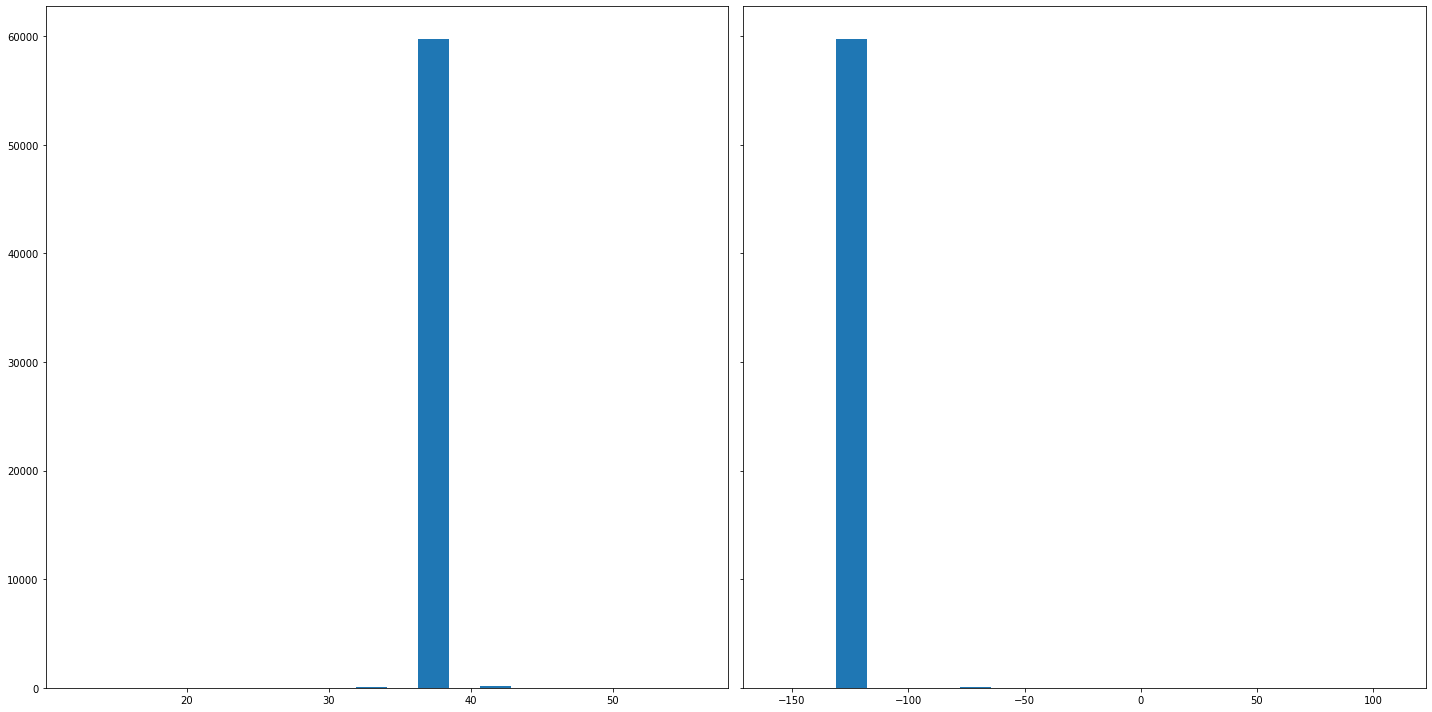

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(20, 10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(full_data['latitude'], bins=20)
axs[1].hist(full_data['longitude'], bins=20)

Eliminamos aquellas personas que estén muy lejos del resto de gente, con el objetivo de que el sesgo no sea la distancia entre personas, y reducir el número de filas que luego afectarán a la RAM.

In [ ]:
print('Total:',len(full_data))
full_data = full_data[(full_data['latitude'] < 40) & (full_data['latitude'] > 36) & (full_data['longitude'] < -110)]
print('Filtrado:',len(full_data))

Total: 59939
Filtrado: 59715


#### `essays` y tratamiento de textos
Sólo quedaría inferir qué pregunta se corresponde a cada una de las *essays*, para obtener una formación mejor categorizada, y procesar los textos.

NOTA: Este paso ya se realizó en su momento e incluyeron los resultados en un .csv el cual leemos y con el que tratamos. Consideramos útil incluir el proceso por el que obtuvimos dichos resultados igualmente, aunque no es necesario ejecutarlo.

In [ ]:
pd.options.display.max_colwidth = 600
pd.options.display.min_rows = 20
display(original_essays)
pd.reset_option("max_colwidth")
pd.reset_option("min_rows")

Según el enunciado, las preguntas a las que responden los campos `essay0-9` son:

1. Acerca de mí / Auto resumen
2. Objetivos actuales / aspiraciones
1. Mi regla de oro / Mis rasgos
1. Probablemente podría ganarte en / Talento
1. La última serie que he visto / Hobbies
1. Un día perfecto / Momentos
1. Yo valoro / Necesito
1. La cosa más privada que estoy dispuesto a admitir / Secretos
1. Lo que realmente estoy buscando / Citas

Pero de primeras podemos observar que hay sólo 9 preguntas y 10 columnas. Tras una inspección más profunda, algunas preguntas no se corresponden con lo respondido tampoco, así que inferimos nosotros qué se pregunta en base a las respuestas.
La clasificación aproximada con la que nos quedamos es la siguiente:


1.   Essay0 => Describe yourself (Acerca de mí / Auto resumen) => `description`
1.   Essay1 => What are you currently doing (Objetivos actuales / aspiraciones) => `goals`
1.   Essay2 => Interesting abilities (Rasgos) => `traits`
1.   Essay3 => What do people normally point attention to about you => `interesting_features`
1.   Essay4 => Favourite books, movies, shows, music and food => `favourites`
1.   Essay5 => What things can you not live without (Yo valoro / Necesito) => `needs`
1.   Essay6 => What worries you/What do you think about => `worries`
1.   Essay7 => How do you normally spend Fridays? => `fridays`
1.   Essay8 => What's one thing people don't know about you (La cosa más privada que estoy dispuesto a admitir / Secretos) => `secret`
1.   Essay9 => What kind of person should contact you? (Lo que realmente estoy buscando / Citas) => `looking_for`




El primer paso será realizar un procesado a los textos, aplicando limpieza de puntuación, eliminación de stop y words y, posteriormente, lematización en base al tipo de palabra que sea y en qué posición se encuentre.

Una vez procesado los textos, usaremos LDA para reducir los esssays y obtener los 3 temas/tópicos principales de cada essay (hemos elegido 3 por tema de RAM y velocidad de procesado, además, de que con 3 essays se explicaba bastante bien todas las respuestas de los usuarios).

In [ ]:
stemmer = SnowballStemmer('english')
lemmatiser = WordNetLemmatizer()
#We only care about the first letter to categorise
tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}

def preprocess(text):
    if type(text) != str:
        return text
    result = []
    tokens = simple_preprocess(text.translate(str.maketrans('', '', string.punctuation)))
    filtered_sentence = [w for w in tokens if w not in STOPWORDS]
    tags = [tag_dict.get(tag[1][0], wordnet.NOUN) for tag in nltk.pos_tag(filtered_sentence)]
    words_with_pos = list(zip(filtered_sentence, tags))
    for token, pos in words_with_pos:
        if len(token) > 3:
            result.append(stemmer.stem(lemmatiser.lemmatize(token, pos=pos)))
    return result

In [ ]:
def lda_essay(essay):
    processed_essay = essay.map(preprocess)
    dictionary = gensim.corpora.Dictionary(processed_essay)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_essay]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
    
    def get_topic(content):
        result = [0,0,0]
        for i in content:
            result[i[0]] = i[1]
        return result
    
    return [get_topic(lda_model_tfidf[i]) for i in bow_corpus]

Si aplicamos este proceso para el primer essay, lo que obtendríamos serían los 3 siguientes temas:

    Topic: 0 
    Words: 0.006*"year" + 0.006*"move" + 0.005*"like" + 0.005*"love" + 0.005*"live" + 0.004*"area" + 0.004*"work" + 0.004*"peopl" + 0.004*"francisco" + 0.004*"go"

    Topic: 1 
    Words: 0.006*"like" + 0.005*"peopl" + 0.005*"look" + 0.005*"know" + 0.005*"life" + 0.005*"love" + 0.005*"dont" + 0.005*"person" + 0.005*"thing" + 0.004*"want"

    Topic: 2 
    Words: 0.008*"love" + 0.006*"like" + 0.005*"enjoy" + 0.005*"life" + 0.005*"good" + 0.005*"friend" + 0.004*"music" + 0.004*"live" + 0.004*"time" + 0.004*"travel"

Así bien, se asignará una proporción de similitud del texto introducido con respecto a cada uno de los temas.

Posteriormente, acumulamos los resultados y los almacenamos en un df

In [ ]:
essays_topics = []
for essay in original_essays.columns:
    essays_topics.append(lda_essay(original_essays[essay]))

In [ ]:
df_essay = pd.DataFrame(essays_topics[0])
for i in range(1,10):
    df_essay = df_essay.join(pd.DataFrame(essays_topics[i], columns=[3*i,3*i+1,3*i+2]))
df_essay.head()

Debido a la lentitud de google colab, importamos los resultados para evitar tener que realizar este proceso repetidamente. (Se ha cargado este dataframe al principio del notebook con el objetivo de mantener consistencia a la hora de filtrar filas, puesto que el df_essays obtiene un df de todas las filas)

In [ ]:
df_essay = pd.read_csv('essays_topics.csv',index_col=False)

## Separación por orientación sexual

Esta separación permitirá tener grupos separados sin ensuciar al resto de clusters. Así, garantizaremos que una persona hetera sólo se mezcle con heteros o bisexuales y una gay, sólo con gays o bisexuales.

Nos deshacemos de las columnas implícitas en cada dataframe, y para el dataset hetero dejamos una columna de sexo (el que no es hombre es mujer y viceversa en este caso), puesto que nos interesa saber el género de los usuarios a la hora de relacionarlos dentro de un cluster, y asumimos que no será suficiente 1 única columna como para que divida los clusters mayormente por sexo. Si se usasen identificadores para los usuarios podría eliminarse ésta también, pero es innecesario.

In [ ]:
full_data

age sex orientation  ...  portuguese   latitude   longitude
0       29   m    straight  ...           0  37.779026 -122.419906
1       32   f    straight  ...           0  37.779026 -122.419906
2       31   f    straight  ...           0  37.779026 -122.419906
3       24   f    straight  ...           0  37.877121 -122.461670
4       37   m    straight  ...           0  37.496904 -122.333057
...    ...  ..         ...  ...         ...        ...         ...
59934   59   f    straight  ...           0  37.804456 -122.271356
59935   24   m    straight  ...           0  37.779026 -122.419906
59936   42   m    straight  ...           0  37.653540 -122.416866
59937   27   m    straight  ...           0  37.779026 -122.419906
59938   39   m         gay  ...           0  37.779026 -122.419906

[59715 rows x 61 columns]

In [ ]:
df_hetero = full_data[(full_data['orientation'] == 'straight') | (full_data['orientation'] == 'bisexual')].drop(columns=['orientation','sex'])
df_hetero

age  body_type  drinks  ...  portuguese   latitude   longitude
0       29          2       2  ...           0  37.779026 -122.419906
1       32          1       2  ...           0  37.779026 -122.419906
2       31          2       2  ...           0  37.779026 -122.419906
3       24          2       2  ...           0  37.877121 -122.461670
4       37          1       0  ...           0  37.496904 -122.333057
...    ...        ...     ...  ...         ...        ...         ...
59933   31          2       2  ...           0  37.779026 -122.419906
59934   59          2       2  ...           0  37.804456 -122.271356
59935   24          1       3  ...           0  37.779026 -122.419906
59936   42          2       0  ...           0  37.653540 -122.416866
59937   27          1       2  ...           0  37.779026 -122.419906

[54161 rows x 59 columns]

In [ ]:
df_gay_male = full_data[((full_data['orientation'] == 'gay') | (full_data['orientation'] == 'bisexual')) & (full_data['sex'] == 'm')].drop(columns=['orientation','sex'])
df_gay_male

age  body_type  drinks  ...  portuguese   latitude   longitude
32      25          1       2  ...           0  37.804456 -122.271356
50      33          1       2  ...           0  37.779026 -122.419906
64      29          0       2  ...           0  37.870839 -122.272864
76      31          2       2  ...           0  37.779026 -122.419906
148     24          0       2  ...           0  37.804456 -122.271356
...    ...        ...     ...  ...         ...        ...         ...
59827   26          0       2  ...           0  37.779026 -122.419906
59903   23          0       2  ...           0  37.779026 -122.419906
59923   41          3       2  ...           0  37.804456 -122.271356
59930   32          0       2  ...           0  37.779026 -122.419906
59938   39          2       2  ...           0  37.779026 -122.419906

[4740 rows x 59 columns]

In [ ]:
df_gay_female = full_data[((full_data['orientation'] == 'gay') | (full_data['orientation'] == 'bisexual')) & (full_data['sex'] == 'f')].drop(columns=['orientation','sex'])
df_gay_female

age  body_type  drinks  ...  portuguese   latitude   longitude
39      29          3       2  ...           1  37.779026 -122.419906
43      31          0       2  ...           0  37.779026 -122.419906
45      33          1       3  ...           0  37.804456 -122.271356
46      38          1       2  ...           0  37.804456 -122.271356
63      31          2       2  ...           0  37.444329 -122.159847
...    ...        ...     ...  ...         ...        ...         ...
59862   32          1       0  ...           0  37.779026 -122.419906
59886   49          4       2  ...           0  37.804456 -122.271356
59894   22          1       2  ...           0  37.779026 -122.419906
59904   22          3       3  ...           0  37.779026 -122.419906
59911   27          3       2  ...           0  37.779026 -122.419906

[3564 rows x 59 columns]

Con esto introducimos datos duplicados, pero prevenimos también el emparejamiento incorrecto de usuarios a cambio de una mínima comprobación en el caso del conjunto hetero.

**SI SE DESEA EVITAR TODO EL PROCESAMIENTO ANTERIOR, EJECUTAR LA SIGUIENTE CELDA:**

In [ ]:
df_gay_female = pd.read_csv('df_gay_female.csv')
df_gay_male = pd.read_csv('df_gay_male.csv')
df_hetero = pd.read_csv('df_hetero.csv')

##Escalado
Aplicamos escalado a fin de no crear ningún sesgo debido a la diferencia en rangos (por ejemplo `income` y `drinks`).

Los escalados aplicados son:


*  $MinMax Scaler$: Escala en base al máximo y mínimo de cada columna y los pone en una escala de 0 a 1. [22]
*   $PowerTransformer$: Aplica una transformación de potencia a cada columna para transformar los datos a una distribución más Gaussiana. [23]



In [ ]:
# Preprocessing numerical
def get_numerical(full_data, scaler="PowerTransformer"):
    numerical = full_data.select_dtypes(exclude='object')
    numerical = numerical.fillna(0)

    for c in numerical.columns:
        transformer = MinMaxScaler() if scaler == "MinMaxScaler" else PowerTransformer()
        numerical.loc[:, c] = transformer.fit_transform(np.array(numerical[c]).reshape(-1, 1))

    return numerical

# Preprocessing categorical
def get_categorical(full_data):
    categorical = full_data.select_dtypes(include='object')
    categorical = pd.get_dummies(categorical)
    columns_to_drop = []
    if "sign_" in categorical.columns:
        columns_to_drop.append("sign_")
    if "religion_other" in categorical.columns:
        columns_to_drop.append("religion_other")
    categorical.drop(columns=columns_to_drop,inplace=True)

    #Percentage of columns which are categorical is used as weight parameter in embeddings later
    categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]
    return categorical

def prepare_dataset(dataframe, scaler="PowerTransformer"):
    return pd.concat([get_numerical(dataframe, scaler), get_categorical(dataframe)], axis=1).reset_index(drop=True)

In [ ]:
dataset_names = ["Homosexual female", "Homosexual male", "Heterosexual"]
datasets = [df_gay_female, df_gay_male, df_hetero]

In [ ]:
minmax_datasets = [prepare_dataset(dataset, "MinMaxScaler") for dataset in datasets]
power_transformer_datasets = [prepare_dataset(dataset) for dataset in datasets]

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2951: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/c

In [ ]:
# Results
display(minmax_datasets[0].head(1))
display(power_transformer_datasets[0].head(1))

age  body_type  ...  religion_islam  religion_judaism
0  0.22449       0.75  ...               0                 0

[1 rows x 77 columns]

age  body_type  ...  religion_islam  religion_judaism
0  0.144922    0.97987  ...               0                 0

[1 rows x 77 columns]

In [ ]:
scaled_datasets = [minmax_datasets, power_transformer_datasets]
scaled_dataset_names = ("MinMax Scaling", "PowerTransform")

---

## Experimentos
Dado que no poseemos ningún *ground truth* ni hay un objetivo de clusters a encontrar, si no que lo que se pide es un análisis puramente exploratorio, haremos múltiples experimentos y en base a los resultados empíricos y la información que hemos recopilado sobre el cliente, elegiremos aquellos que nos parezcan más relevantes para el modelo de negocio en cuestión.

Utilizaremos la métrica *silhouette* allá donde podamos, de nuevo más como punto de referencia que como comparación directa, puesto que es un problema que en última instancia (y por ahora) recae en el criterio del ingeniero, no de un modelo.

### Análisis por Clustering

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering

#### K-Means

In [ ]:
def plot_kmeans_graphs(n, data, names, title, width=10, height = 5):
    fig, axs = plt.subplots(ncols=n, figsize=(width*n, height))
    fig.suptitle(title,fontsize=20)
    for i in range(n):
        label = data[i].labels_
        unique, counts = np.unique(label, return_counts=True)
        axs[i].set_title(f"{names[i]}")
        axs[i].bar(unique,counts)
    plt.show()

def perform_kmeans(n_clusters):
    for i in range(len(scaled_datasets)):
        prepared_datasets = scaled_datasets[i]
        title = scaled_dataset_names[i]
        kmeans_list = []
        print(f"With {title}")
        for j in range(len(prepared_datasets)):
            kmeans_list.append(KMeans(random_state=seed, n_clusters=n_clusters).fit(X=prepared_datasets[j]))
            print(f"\t{dataset_names[j]}:\tSilhouette: {silhouette(prepared_datasets[j], kmeans_list[-1].labels_, random_state=seed)}")
        plot_kmeans_graphs(3, data = kmeans_list, names=dataset_names, title=title)
        

Con 2 clusters:

With MinMax Scaling
	Homosexual female:	Silhouette: 0.05652048731973073
	Homosexual male:	Silhouette: 0.058297558776369655
	Heterosexual:	Silhouette: 0.060984533264333465


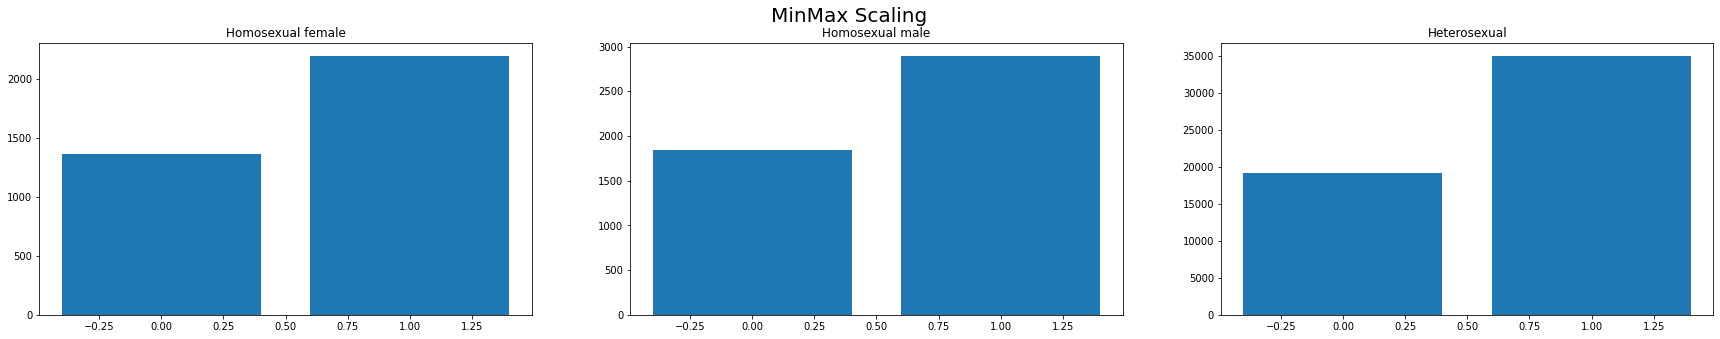

With PowerTransform
	Homosexual female:	Silhouette: 0.031599524712576224
	Homosexual male:	Silhouette: 0.035108593488811346
	Heterosexual:	Silhouette: 0.03481679102858575


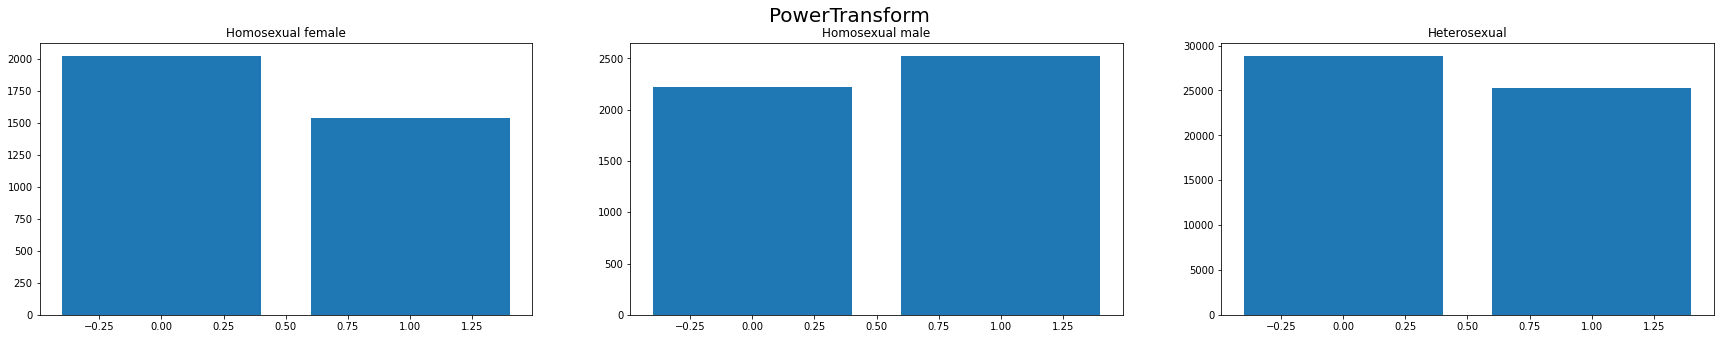

In [ ]:
perform_kmeans(2)

Con 5 clusters:

With MinMax Scaling
	Homosexual female:	Silhouette: 0.03858365673953296
	Homosexual male:	Silhouette: 0.031542532026049265
	Heterosexual:	Silhouette: 0.028628170912440635


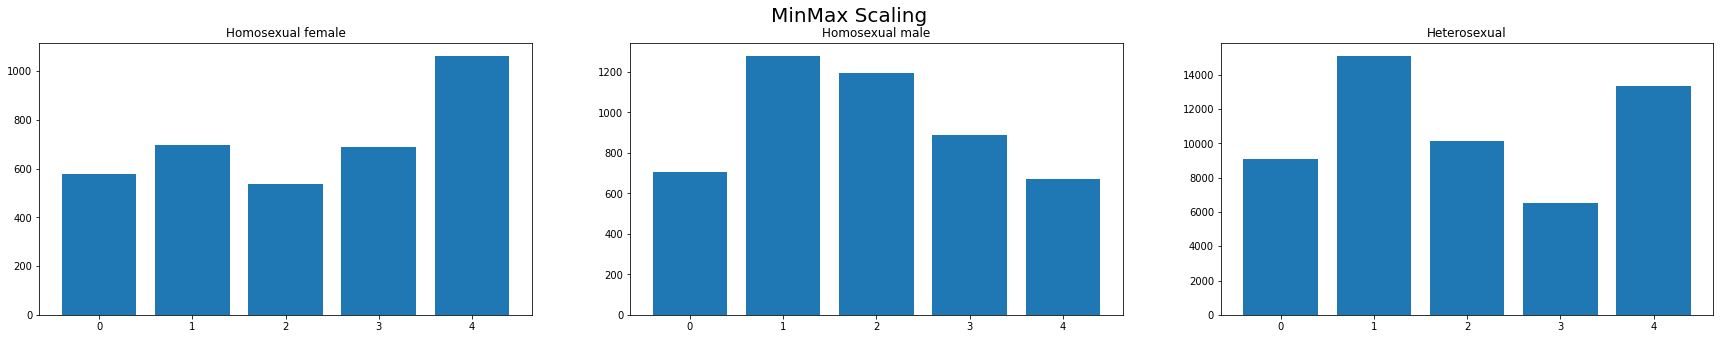

With PowerTransform
	Homosexual female:	Silhouette: 0.031132057110957782
	Homosexual male:	Silhouette: 0.03601689246845659
	Heterosexual:	Silhouette: 0.03261784191714152


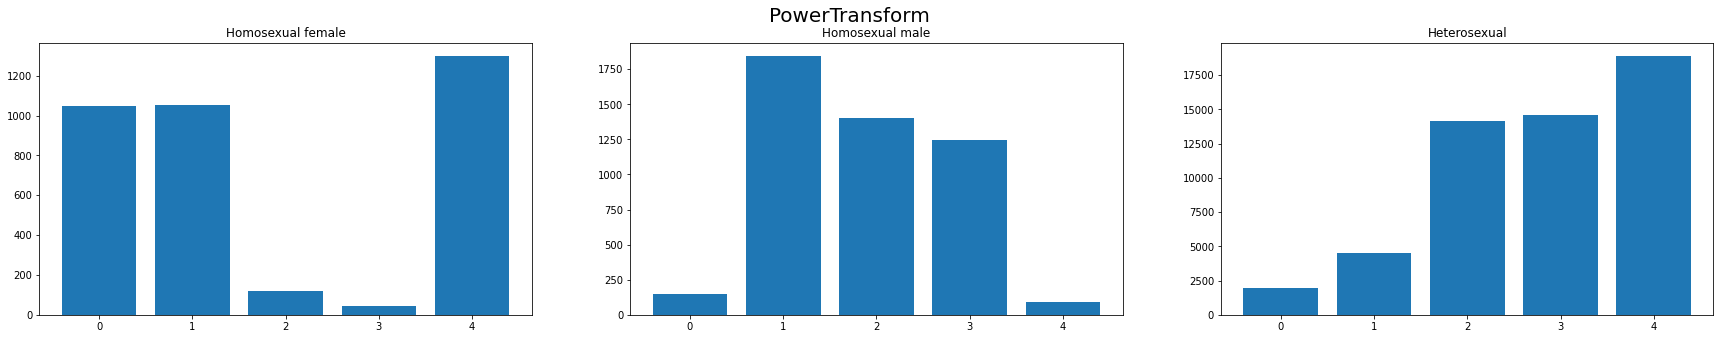

In [ ]:
perform_kmeans(5)

Con 10 clusters:

With MinMax Scaling
	Homosexual female:	Silhouette: 0.030174070135765983
	Homosexual male:	Silhouette: 0.019887006009430944
	Heterosexual:	Silhouette: 0.015244358702005715


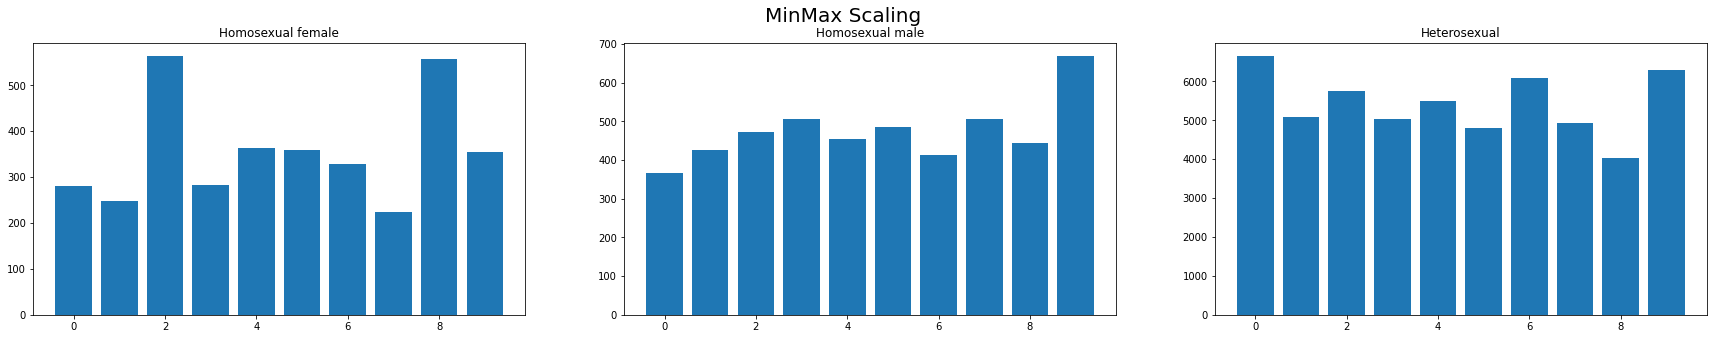

With PowerTransform
	Homosexual female:	Silhouette: 0.019502010612785725
	Homosexual male:	Silhouette: 0.021053938454470848
	Heterosexual:	Silhouette: 0.016574762741877434


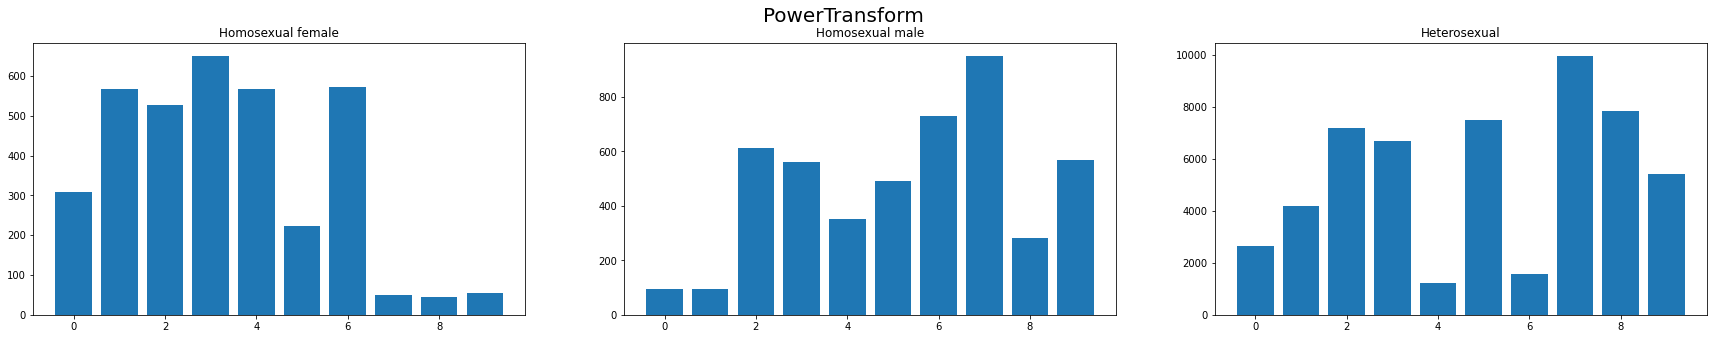

In [ ]:
perform_kmeans(10)

#### DBSCAN
NOTA: Por motivos de RAM, no podemos calcular la distancia máxima entre vecinos para empezar a estimar $\varepsilon$ ni podemos usar DBSCAN en el conjunto de datos de heterosexuales.

In [ ]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

distances = []
for i in range(len(scaled_datasets)):
    distances.append([])
    prepared_datasets = scaled_datasets[i]
    print(f"With {scaled_dataset_names[i]}:")
    for j in range(len(prepared_datasets)-1): # Big one crashes due to insufficient RAM
        distances[i].append(kneighbors_graph(prepared_datasets[j], len(prepared_datasets[j])-1, mode='distance').todense().flatten().max())
    print(distances[i])

With MinMax Scaling:
[4.9503775652880755, 4.865251756761114]
With PowerTransform:
[36.04716638157568, 26.29663114653364]


Usamos el valor medio de cada una como punto inicial para $\varepsilon$

In [ ]:
for i in range(len(scaled_datasets)):
    prepared_datasets = scaled_datasets[i]
    print(f"With {scaled_dataset_names[i]}:")
    for j in range(len(prepared_datasets)-1): #Big one crashes
        db_scan = DBSCAN(eps=distances[i][j]/2, min_samples=int(len(prepared_datasets[j])/4), n_jobs=-1)
        result = db_scan.fit_predict(prepared_datasets[j])
        print(f"\t{dataset_names[j]}:\tSilhouette: {silhouette(prepared_datasets[j],result, random_state=seed)}\tClusters: {np.unique(result)}")

With MinMax Scaling:
	Homosexual female:	Silhouette: 0.03974714828038564	Clusters: [-1  0]
	Homosexual male:	Silhouette: 0.0579502924258521	Clusters: [-1  0]
With PowerTransform:
	Homosexual female:	Silhouette: 0.553516283391426	Clusters: [-1  0]
	Homosexual male:	Silhouette: 0.5226243481055513	Clusters: [-1  0]


Los valores de *silhouette* son sorprendentemente altos, lo que indica una alta correlación entre elementos del mismo cluster pero muy baja con elementos de otros clusters. Dicho eso, sólo ha descubierto 2 clusters en ambos casos, lo que lleva a pensar que la distancia es demasiado alta y engloba a demasiados puntos y/o que hay outliers. Esto es un resultado típico de DBSCAN.

Y para optimizar $\varepsilon$ podemos usar un GridSearch o una técnica más visual: encontrar el codo de la curva de distancias hasta $minPoints - 1$ vecinos. El procedimiento exacto es el siguiente:

> Hay un proceso para determinar valores óptimos (locales) para los hiper-parámetros del algoritmo:

> * Se calculan las distancias desde cada punto a los $minPoints - 1$ más cercanos.

> * Se ordenan las distancias, se plotean y se elige el $\varepsilon$ donde la curva es más pronunciada


MinMax Scaling


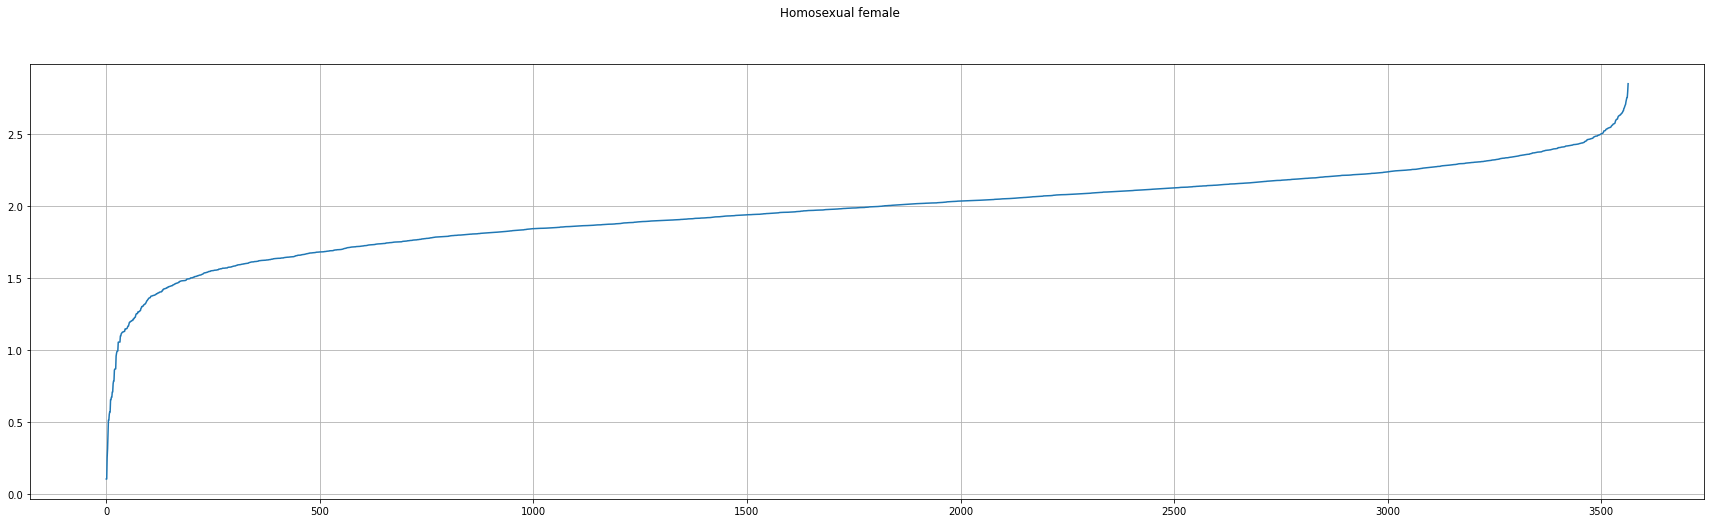

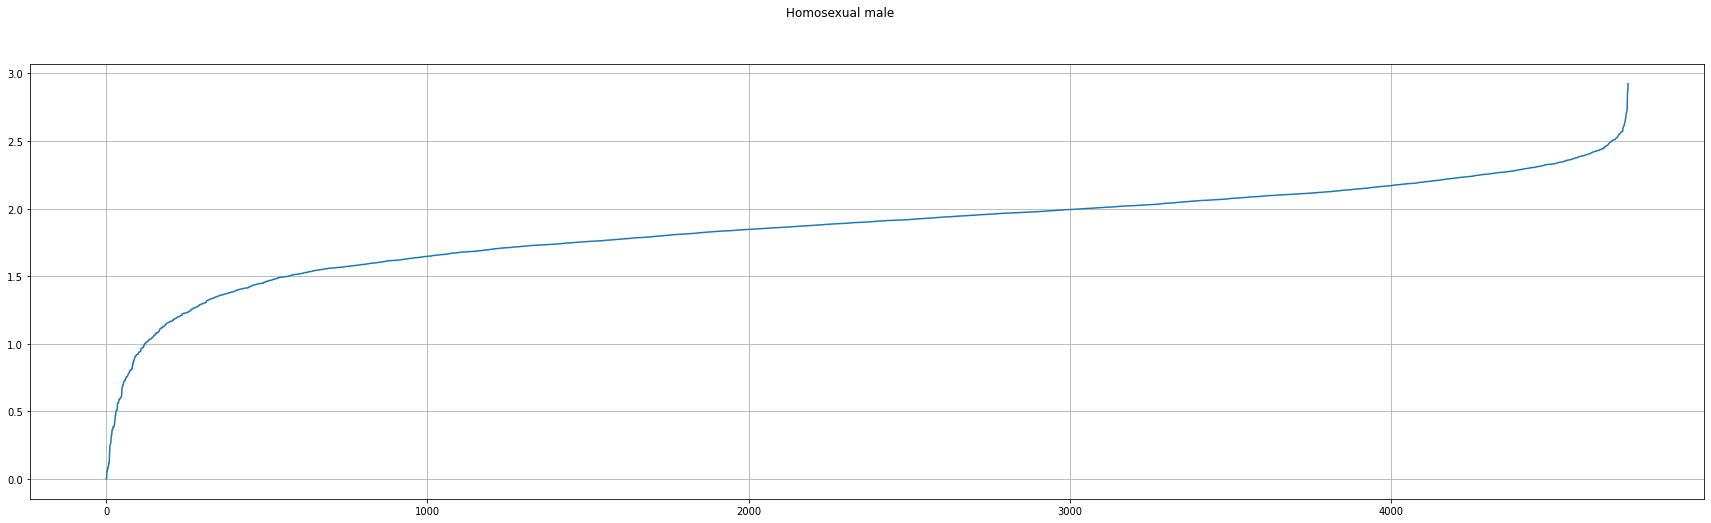

PowerTransform


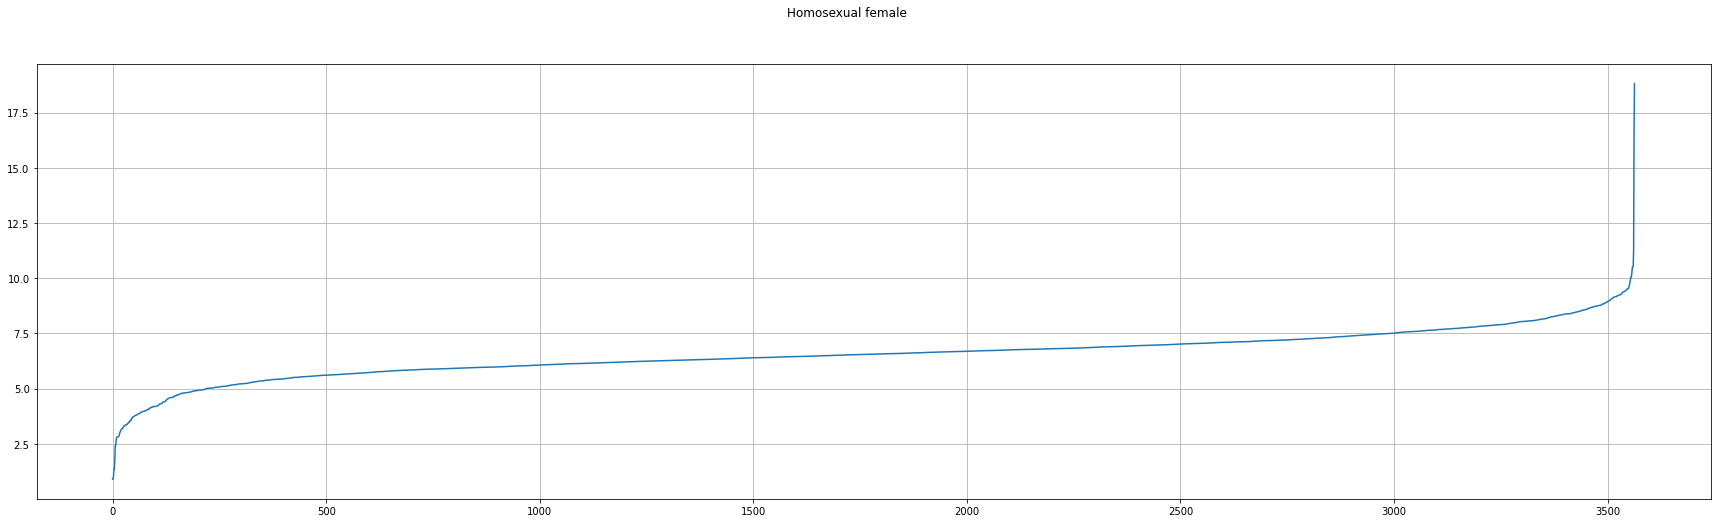

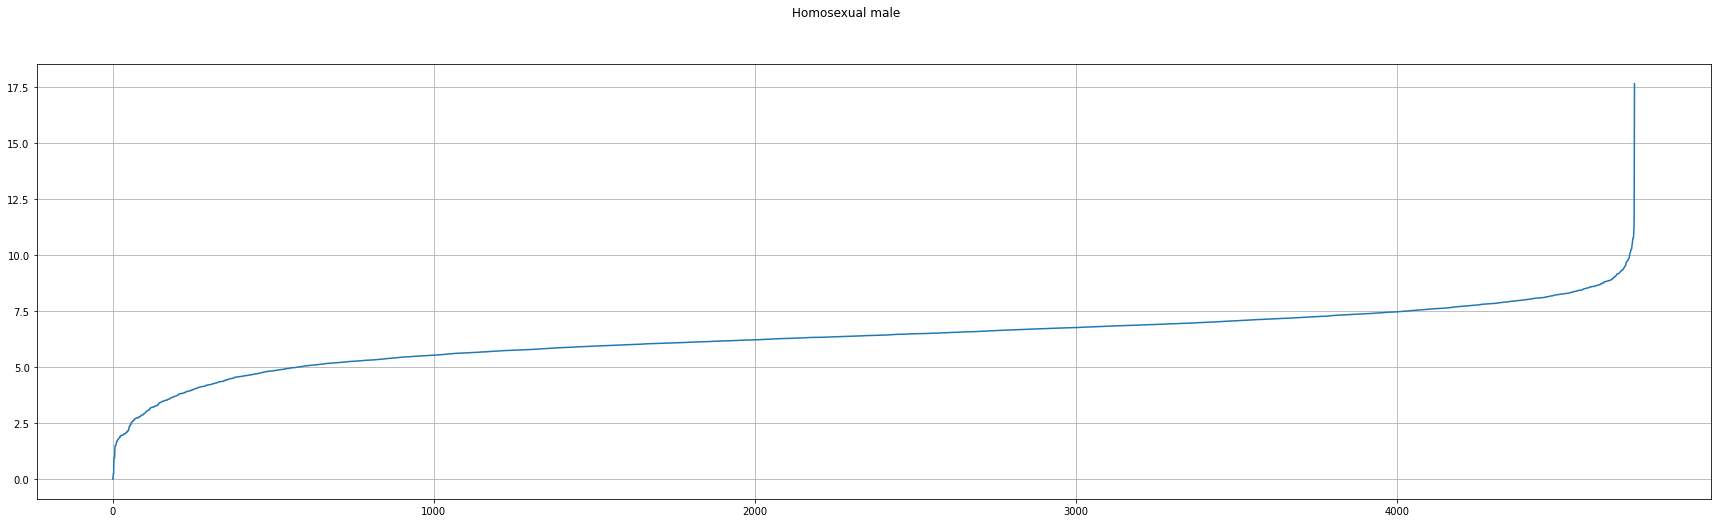

In [ ]:
for i in range(len(scaled_datasets)):
    prepared_datasets = scaled_datasets[i]
    print(scaled_dataset_names[i])
    for j in range(len(prepared_datasets)-1):#Big one crashes
        data = prepared_datasets[j]
        neigh = NearestNeighbors(n_neighbors=int(len(data)/4))
        nbrs = neigh.fit(data)
        distances, indices = nbrs.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        fig = plt.figure(figsize=(30,8))
        fig.suptitle(dataset_names[j])
        plt.grid(True)
        plt.plot(distances)
    plt.show()

Para $MinMax Scaling$ comprobamos que esto es en torno a $\varepsilon = 2.5$ y para $PowerTransform$ en torno a $\varepsilon = 8.5$

In [ ]:
distances = [2.5, 8.5]
for i in range(len(scaled_datasets)):
    prepared_datasets = scaled_datasets[i]
    print(f"With {scaled_dataset_names[i]}:")
    for j in range(len(prepared_datasets)-1): #Big one crashes
        db_scan = DBSCAN(eps=distances[i], min_samples=int(len(prepared_datasets[j])/4), n_jobs=-1)
        result = db_scan.fit_predict(prepared_datasets[j])
        print(f"\t{dataset_names[j]}:\tSilhouette: {silhouette(prepared_datasets[j],result, random_state=seed)}\tClusters: {np.unique(result)}")

With MinMax Scaling:
	Homosexual female:	Silhouette: 0.0478261568210507	Clusters: [-1  0]
	Homosexual male:	Silhouette: 0.08067111249619932	Clusters: [-1  0]
With PowerTransform:
	Homosexual female:	Silhouette: 0.13649084566044561	Clusters: [-1  0]
	Homosexual male:	Silhouette: 0.13574164025046004	Clusters: [-1  0]


De nuevo, sólo 2 clusters pero en este caso son mejores. Se podría probar usando $GridSearch$ a optimizar de manera más formal en un futuro.

#### Clustering Jerárquico (Hierarchichal/Agglomerative Clustering)

Basados en la documentación presente en [14]:
> Agglomerative cluster has a “rich get richer” behavior that leads to uneven cluster sizes. In this regard, single linkage is the worst strategy, and Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative. Single linkage, while not robust to noisy data, can be computed very efficiently and can therefore be useful to provide hierarchical clustering of larger datasets. Single linkage can also perform well on non-globular data.

Optamos por una vinculación o *linkage* de tipo ward para obtener clusters de tamaños similares y evitar la agrupación de un enorma número de usuarios en un único cluster.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
sys.setrecursionlimit(10000)

With MinMax Scaling:


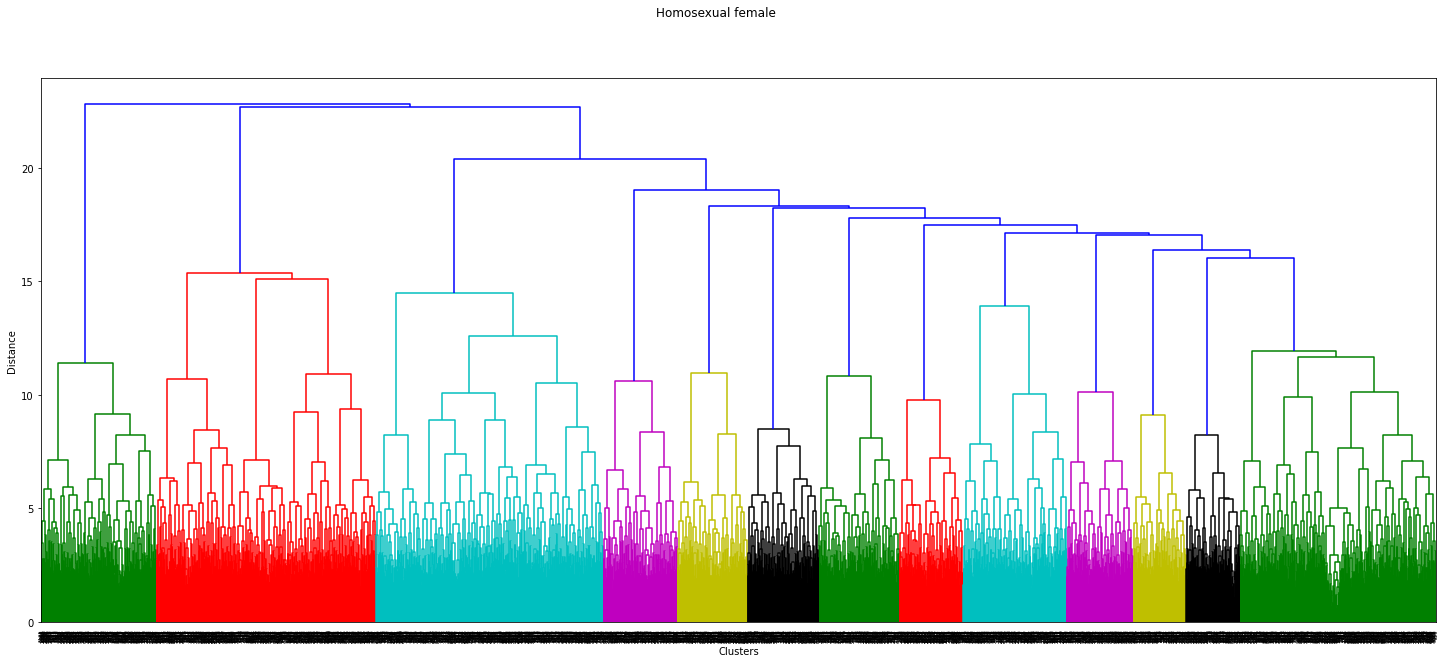

In [ ]:
for i in range(len(scaled_datasets)):
    prepared_datasets = scaled_datasets[i]
    print(f"With {scaled_dataset_names[i]}:")
    for j in range(len(prepared_datasets)-1): # Big one crashes
        fig = plt.figure(figsize=(20, 10))
        fig.suptitle(dataset_names[j])
        plt.xlabel('Clusters')
        plt.ylabel('Distance')
        plt.xticks(rotation=90)
        dendrogram(linkage(np.array(prepared_datasets[j]), method="ward", optimal_ordering=True), distance_sort='descending')
        plt.show()

In [ ]:
# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

With MinMax Scaling:


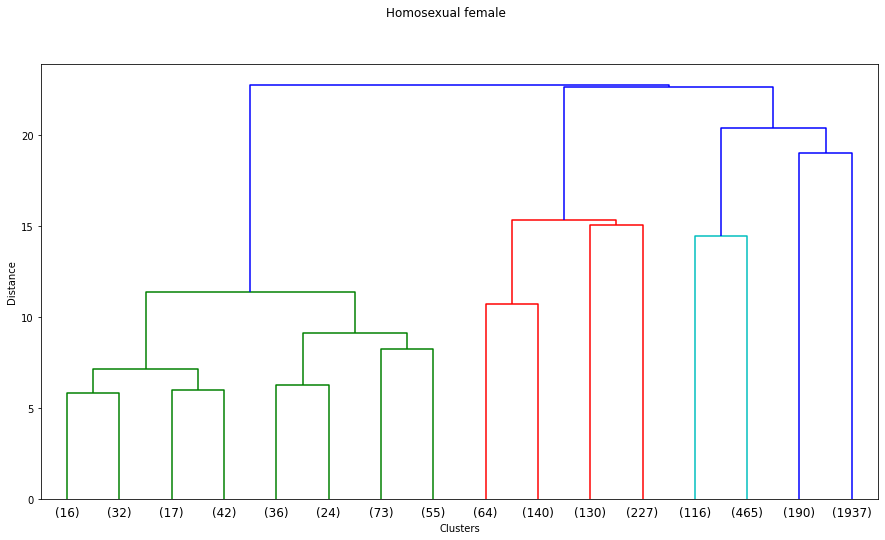

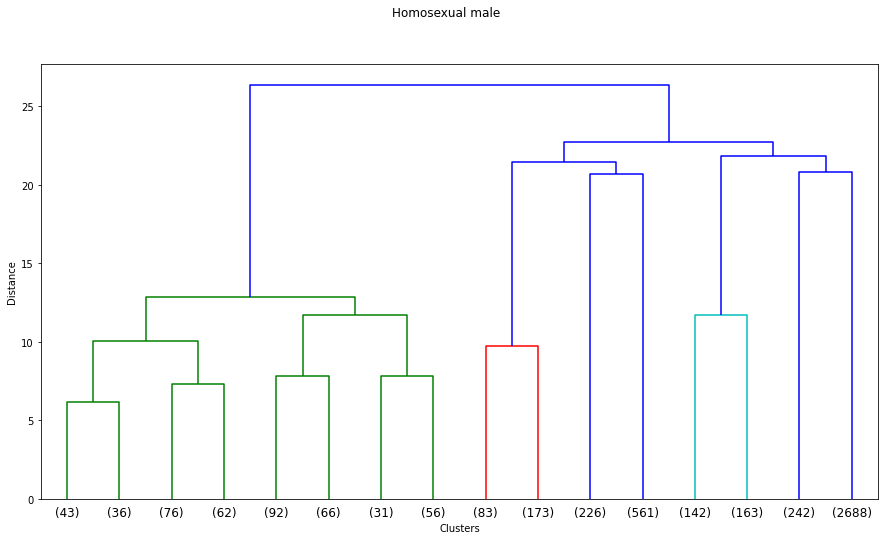

With PowerTransform:


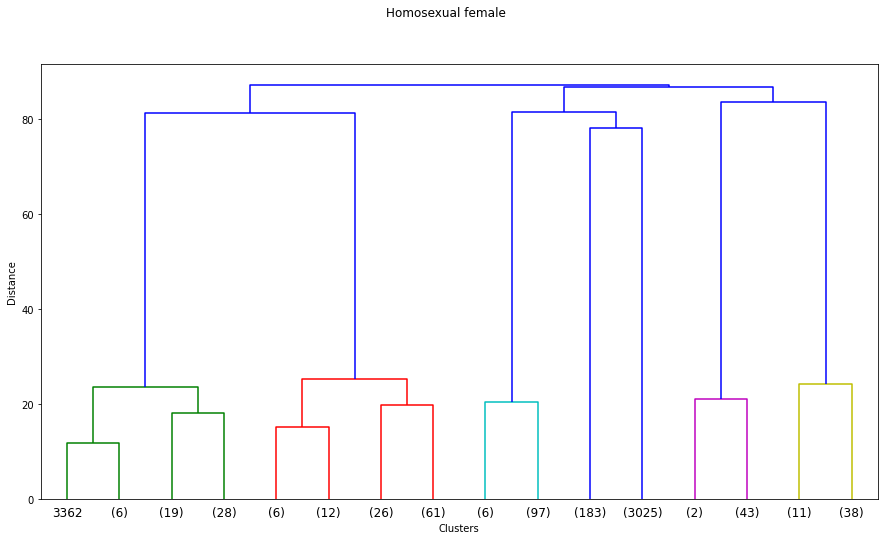

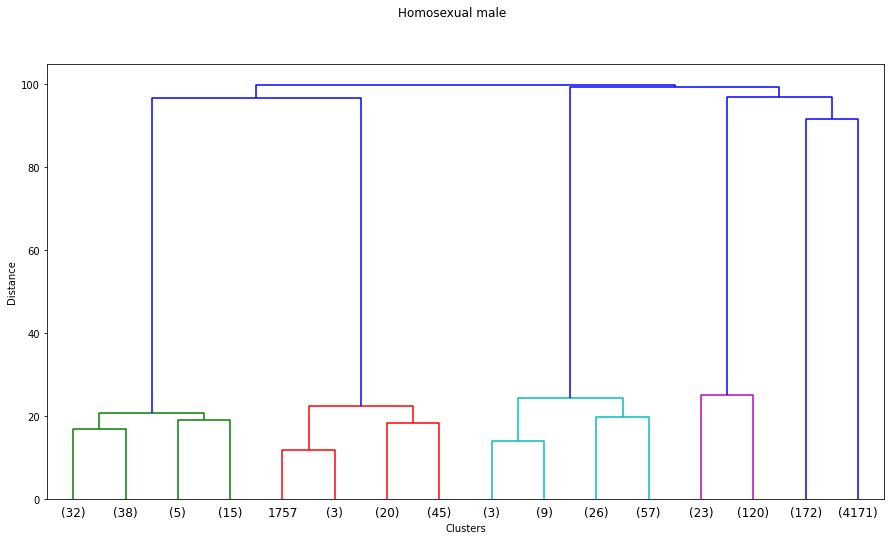

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1)

for i in range(len(scaled_datasets)):
    prepared_datasets = scaled_datasets[i]
    print(f"With {scaled_dataset_names[i]}:")
    for j in range(len(prepared_datasets)-1): # Big one crashes
        fig = plt.figure(figsize=(15, 8))
        fig.suptitle(dataset_names[j])
        plt.xlabel('Clusters')
        plt.ylabel('Distance')
        plt.xticks(rotation=90)
        plot_dendrogram(agg_clustering.fit(prepared_datasets[j]), truncate_mode='level', p=3)
        plt.show()

#### Spectral Clustering

En base a la documentación [14]:
> The present version of SpectralClustering requires the number of clusters to be specified in advance. It works well for a small number of clusters, but is not advised for many clusters.

Por ello probaremos con un pequeño número de clusters, aunque tememos que no aporte resultados útiles.

In [ ]:
results = []
spectral_clustering = SpectralClustering(random_state = seed)
for i in range(2): # Big one crashes
    results.append(spectral_clustering.fit(datasets[i]))

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


Por desgracia tarda demasiado como para realizar múltiples experimentos o comprobar los resultados, e incluso crashea al probar con el dataset grande, aunque podría haber otorgado información bastante útil. Descartamos por ende este método, conocido por su escasa escalabilidad.

---
### Reducción de Dimensionalidades

Con la reducción de dimensionalidades esperamos encontrar aquellas features que sean realmente relevantes al problema y representar gráficamente los conjuntos de datos a fin de encontrar patrones.

In [ ]:
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import Isomap

#### PCA

In [ ]:
def pca_data_kmeans(df, clusters, scaler='PowerTransformer'):
  X = prepare_dataset(df, scaler)

  pca = PCA(2)  # project from 64 to 2 dimensions
  projected = pca.fit_transform(X)
  print(X.shape)
  print(projected.shape)

  kmeans = KMeans(random_state=seed, n_clusters=clusters).fit(X=X)
  labels = kmeans.labels_
  print(silhouette(X,labels))
  plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

  plt.scatter(projected[:, 0], projected[:, 1],
              c=labels, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('tab20c', clusters))
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.colorbar();

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


(3564, 77)
(3564, 2)
0.028967852565706182
(3564, 77)
(3564, 2)
0.046939926320125155


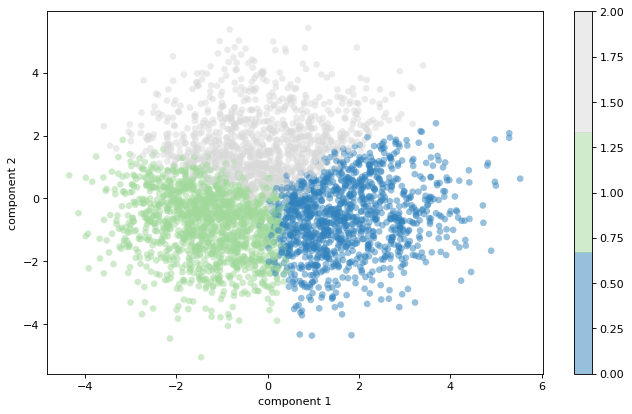

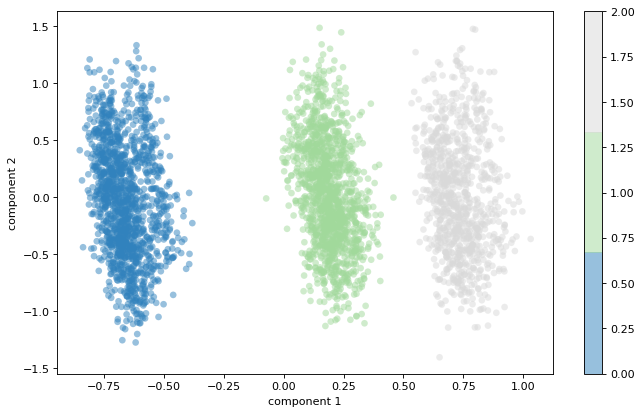

In [ ]:
pca_data_kmeans(df_gay_female,3, 'PowerTransformer')
pca_data_kmeans(df_gay_female,3, 'MinMaxScaler')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2951: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


(4740, 77)
(4740, 2)
0.03099073928007023
(4740, 77)
(4740, 2)
0.03356427500170207


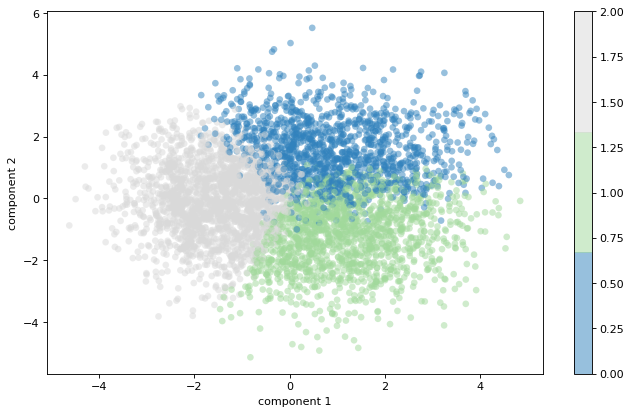

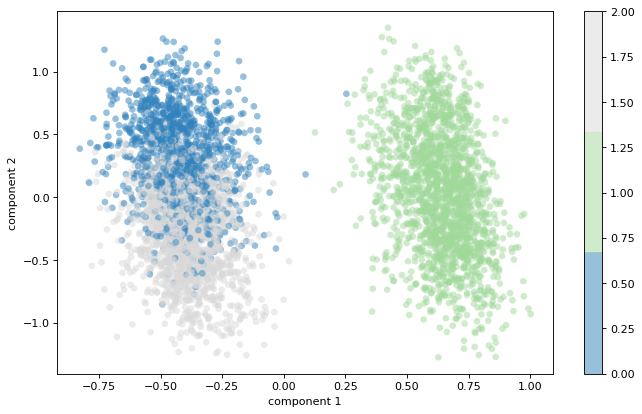

In [ ]:
pca_data_kmeans(df_gay_male,3, 'PowerTransformer') 
pca_data_kmeans(df_gay_male,3, 'MinMaxScaler')

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


(54161, 77)
(54161, 2)
(54161, 77)
(54161, 2)


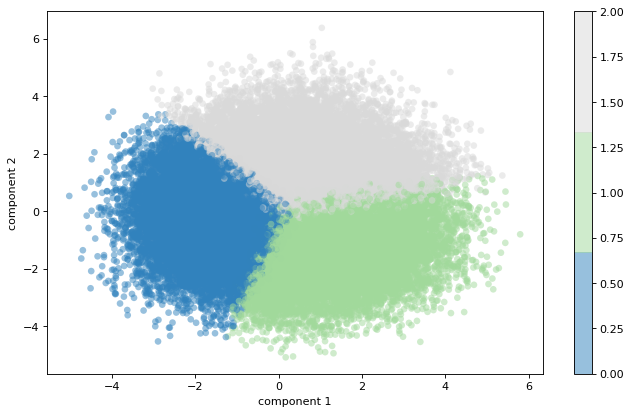

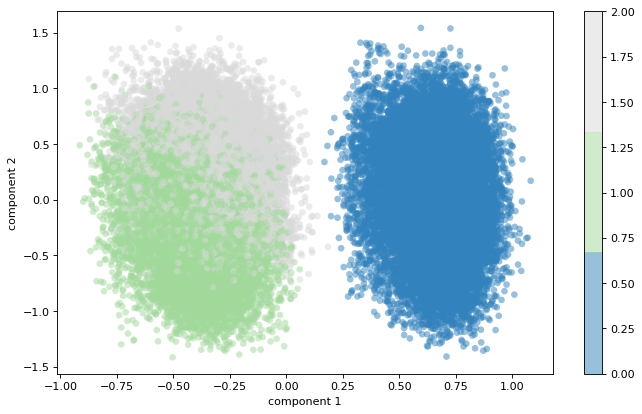

In [ ]:
pca_data_kmeans(df_hetero,3, 'PowerTransformer')
pca_data_kmeans(df_hetero,3, 'MinMaxScaler')

#### ISOMAP

In [ ]:
def isomap_data_kmeans(df, clusters, name):
  X = df
  isomap = Isomap(n_neighbors=30, n_components=2)
  X_projected = isomap.fit_transform(X)
  kmeans = KMeans(random_state=seed, n_clusters=clusters).fit(X=X)

  fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
  fig.suptitle(name)
  plt.scatter(X_projected[:, 0], X_projected[:, 1],
              c=kmeans.labels_, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('tab20c', clusters))
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.colorbar();

With MinMax Scaling:


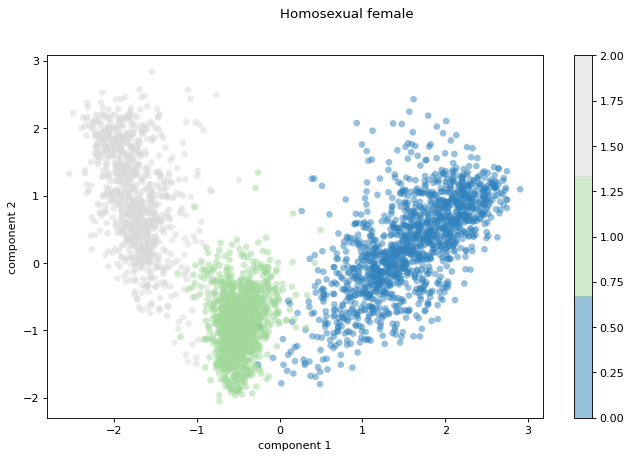

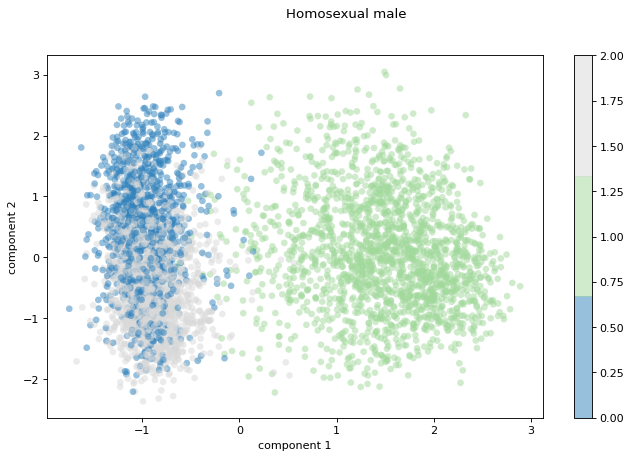

In [ ]:
print(f"With {scaled_dataset_names[0]}:")
for i in range(len(scaled_datasets[0])-1): #Big one crashes
    isomap_data_kmeans(scaled_datasets[0][i], 3, dataset_names[i])

With PowerTransform:


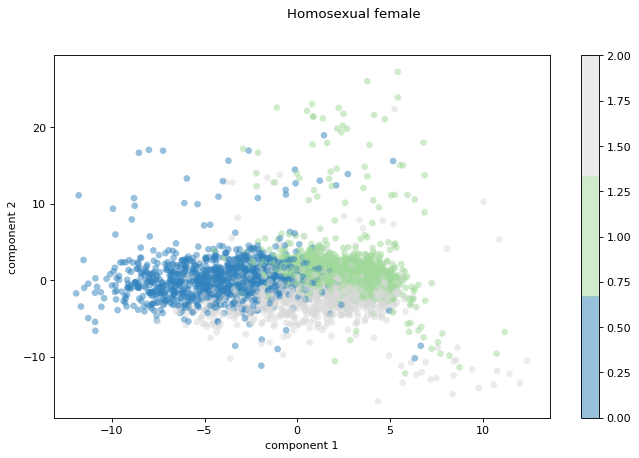

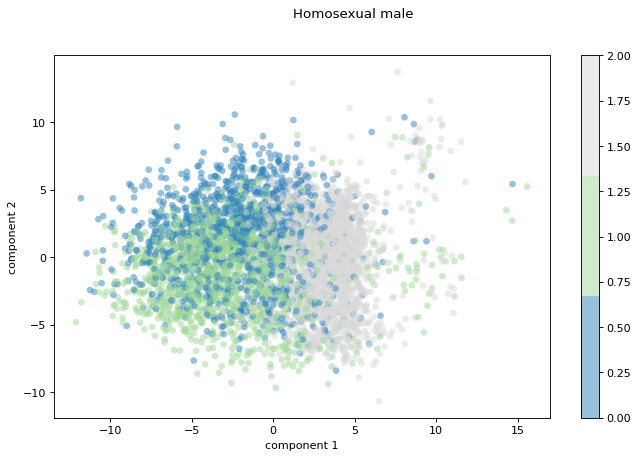

In [ ]:
print(f"With {scaled_dataset_names[1]}:")
for i in range(len(scaled_datasets[1])-1): #Big one crashes
    isomap_data_kmeans(scaled_datasets[1][i], 3, dataset_names[i])

#### TSNE

In [ ]:
def tsne_data_kmeans(df, clusters, name):
    X = df
    tsne = TSNE(n_jobs=4, perplexity=100)
    embeddings = tsne.fit_transform(X)

    kmeans = KMeans(random_state=seed, n_clusters=clusters).fit(X=X)

    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.suptitle(name)
    plt.scatter(embeddings[:, 0], embeddings[:, 1],
                c=kmeans.labels_, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('tab20c', clusters))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()
    plt.show()

With MinMax Scaling:
With PowerTransform:


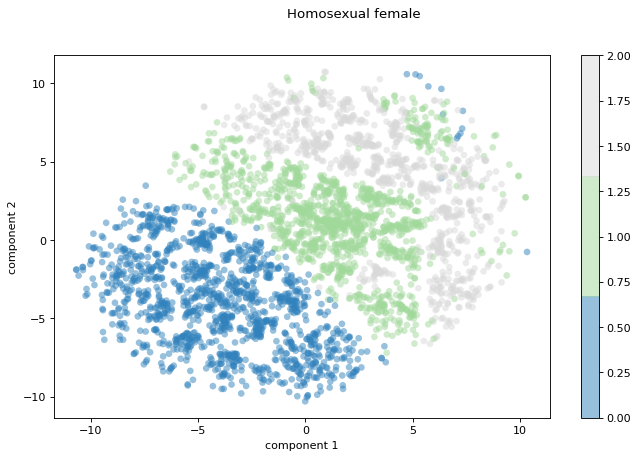

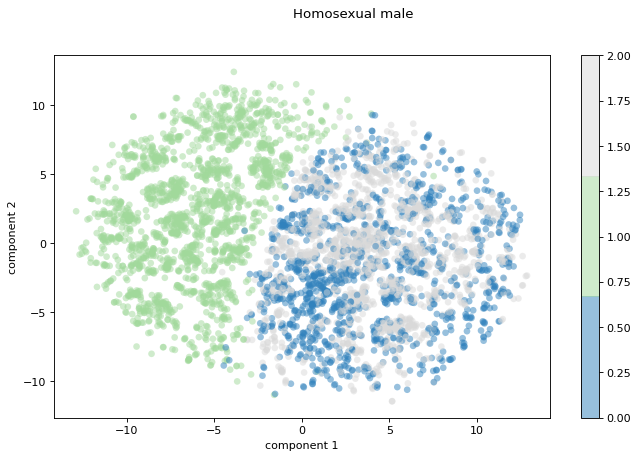

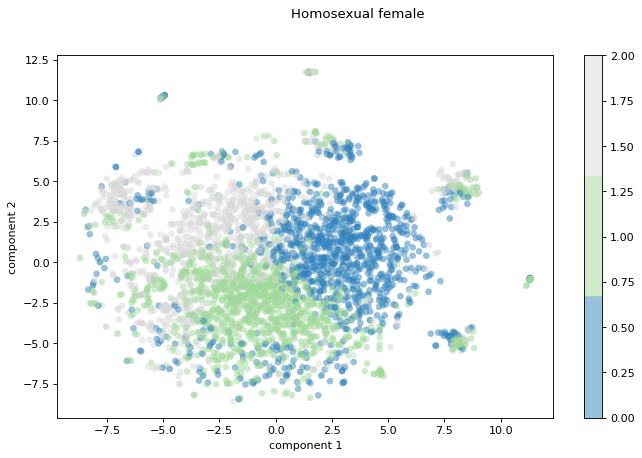

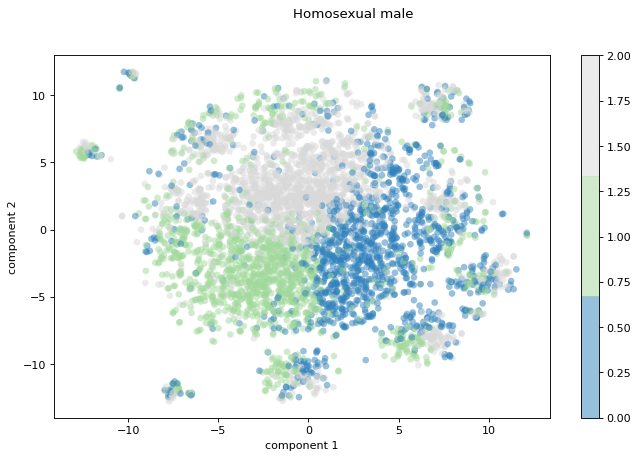

In [ ]:
for i in range(len(scaled_datasets)):
    prepared_dataset = scaled_datasets[i]
    print(f"With {scaled_dataset_names[i]}:")
    for j in range(len(prepared_dataset)-1):
        tsne_data_kmeans(prepared_dataset[j], 3, dataset_names[j])

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


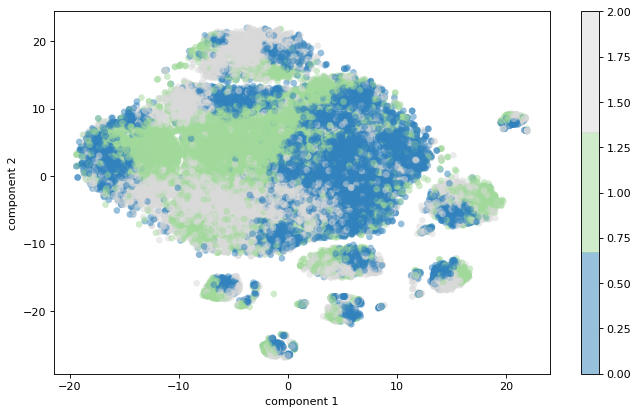

In [ ]:
tsne_data_kmeans(scaled_datasets[0][2], 3) # Hetero MinMax
tsne_data_kmeans(scaled_datasets[1][2], 3) # Hetero PowerTransform

##Conclusión
El aprendizaje exploratorio suele tener unos resultados muy "difuminados", sobretodo cuando no se tiene un objetivo particular en mente, como es este caso, en el que se debía relacionar a personas en base a similitudes, teniendo como única guía el hecho de que en OkCupid se da mucha importancia a las descripciones de uno mismo. En base a los datos y pocos experimentos realizados, hemos obtenido resultados muy variados, y quedaría a elección de la compañía escoger cuál de los métodos les parece que da mejores resultados en un entorno de producción con usuarios reales.

Debido al enorme número de features (el cual redujimos al máximo posible, pero llegamos a contar con más de 800 columnas en un momento) y la subjetividad al calcular distancias inherentes a éstos, obtener unos resultados concisos con un silhouette elevado es altamente improbable, al contrario que se podría intentando clasificar colores, números o cualquier conjunto de datos más claramente segregables.

## Referencias
1.   https://www.okcupid.com/about
2. https://www.theguardian.com/lifeandstyle/2014/sep/28/seven-secrets-of-dating-from-the-experts-at-okcupid
3. https://medium.com/@sm_app_intel/conquer-love-with-these-crucial-dating-app-statistics-2870ec5493cd
4. https://www.businessofapps.com/data/tinder-statistics/
5. https://www.cnbc.com/2012/02/01/12-Unique-Dating-Sites.html
6. https://www.mayoclinic.org/es-es/diseases-conditions/dwarfism/symptoms-causes/syc-20371969
1. https://docs.python.org/3/library/random.html
1. https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
1. https://www.nltk.org/api/nltk.stem.html
1. https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
1. https://www.nltk.org/book/ch05.html
7. https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
7. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

1. https://scikit-learn.org/stable/modules/clustering.html
1. https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://towardsdatascience.com/
6. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
22. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
23. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html



No hemos incluido parte de Testing porque para cuando nos acordamos la mayoría de los tests los habíamos hecho ya, y al fin y al cabo lo importante es el trabajo en sí. Esperamos que no suponga un problema

---
# Elementos descartados
Aquí tenemos todas aquellas celdas que realizamos en su momento pero decidimos descartar por encontrar métodos mejores o por limitaciones de RAM en los experimentos.

#### `height`

Viendo los valores de altura, asumimos que estarán en pulgadas (sistema americano/imperial), y que hay ciertos valores extremadamente pequeños, que asumimos que son falsos dado que parece una pregunta que no era obligatorio responder en el momento de registro puesto que hay valores NaN, los cuales simbolizan que se podía dejar en blanco.

In [ ]:
df.height.unique()

array([75., 70., 68., 71., 66., 67., 65., 72., 62., 64., 69., 73., 74.,
       60., 63., 76., 61., 78., 79., 59., 80., 91., 83., 77., 58., 56.,
       95., 57., 87., 81., 36., 43., 52., 55., 53., 93.,  8., 54., 82.,
        3., 86., 42., 84., 94., 50.,  6., 47., 49., 48., 90., 88., nan,
       37.,  9., 51.,  1., 92., 26., 85., 89.,  4.])

Para decidir a partir de qué momento asumir que una altura es falsa, comprobamos primero de dónde son las personas que aparecen en estos datos:

In [ ]:
df.location.describe()

count                         59944
unique                          199
top       san francisco, california
freq                          31063
Name: location, dtype: object

In [ ]:
df.location.value_counts()#.to_dict() #To see the entire list, not just the beginning and end

san francisco, california    31063
oakland, california           7214
berkeley, california          4212
san mateo, california         1331
palo alto, california         1064
                             ...  
honolulu, hawaii                 1
nevada city, california          1
billings, montana                1
waterford, california            1
guadalajara, mexico              1
Name: location, Length: 199, dtype: Int64

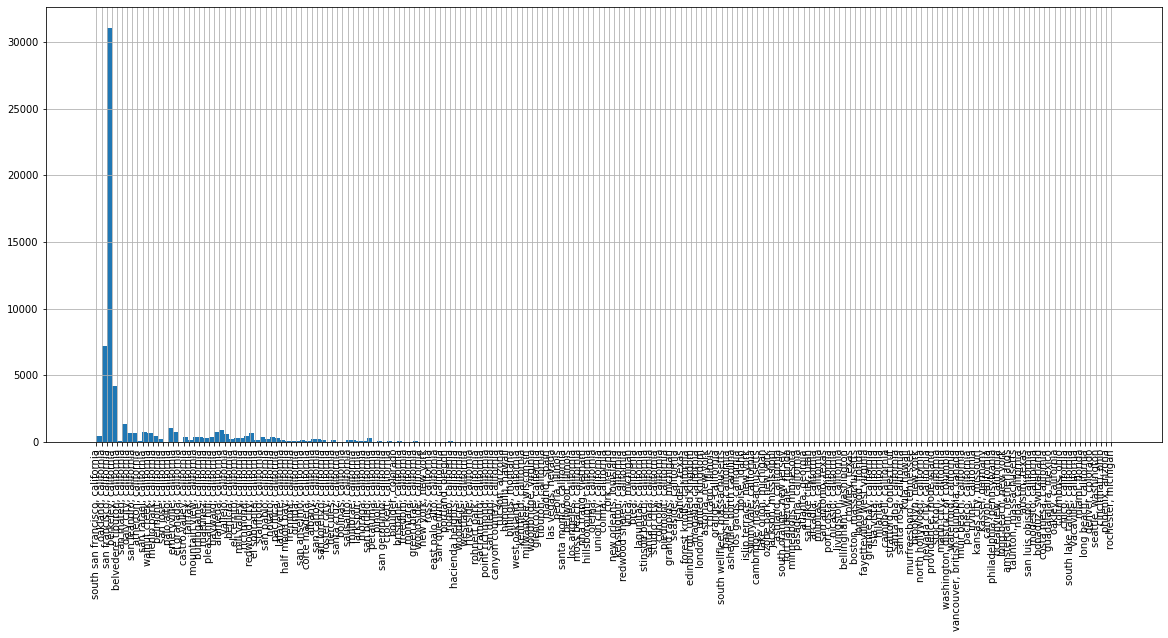

In [ ]:
df.location.hist(figsize=(20,8), bins=df.location.nunique(), xrot=90)

Claramente predominan los usuarios de Norteamérica, con más de la mitad siendo de San Francisco. Por ello, usaremos las alturas de EEUU como límite para hombres y mujeres. Las personas con enanismo serían el límite inferior, por ende cualquier altura por debajo de las 36 pulgadas, o 91 cm, será falsa según [6]. Toda altura falsa la transformaremos a la media de nuestros datos, a fin de no introducir ningún sesgo significativo.

In [ ]:
mean_height = df[df["height"]>=36].height.mean()
mean_height

68.3018820702773

In [ ]:
df.height = df.height.apply(lambda x: x if x >= 36 else mean_height)
df.height.describe()

count    59944.000000
mean        68.301882
std          3.939123
min         36.000000
25%         66.000000
50%         68.000000
75%         71.000000
max         95.000000
Name: height, dtype: float64



---


Destaca que hay una gran cantidad de localizaciones con 1 única persona, las 
cuales no nos sirven en absoluto para poder agrupar, y que por ende simplemente borraremos.

In [ ]:
locations_df = locations_df.drop(labels=list({key:value for key,value in sum_dict.items() if value == 1}.keys()), axis=1)
sorted_sum_list = sorted({key:value for key,value in locations_df.sum().to_dict().items()}.items(), key=lambda x: x[1], reverse=True)

<BarContainer object of 20 artists>

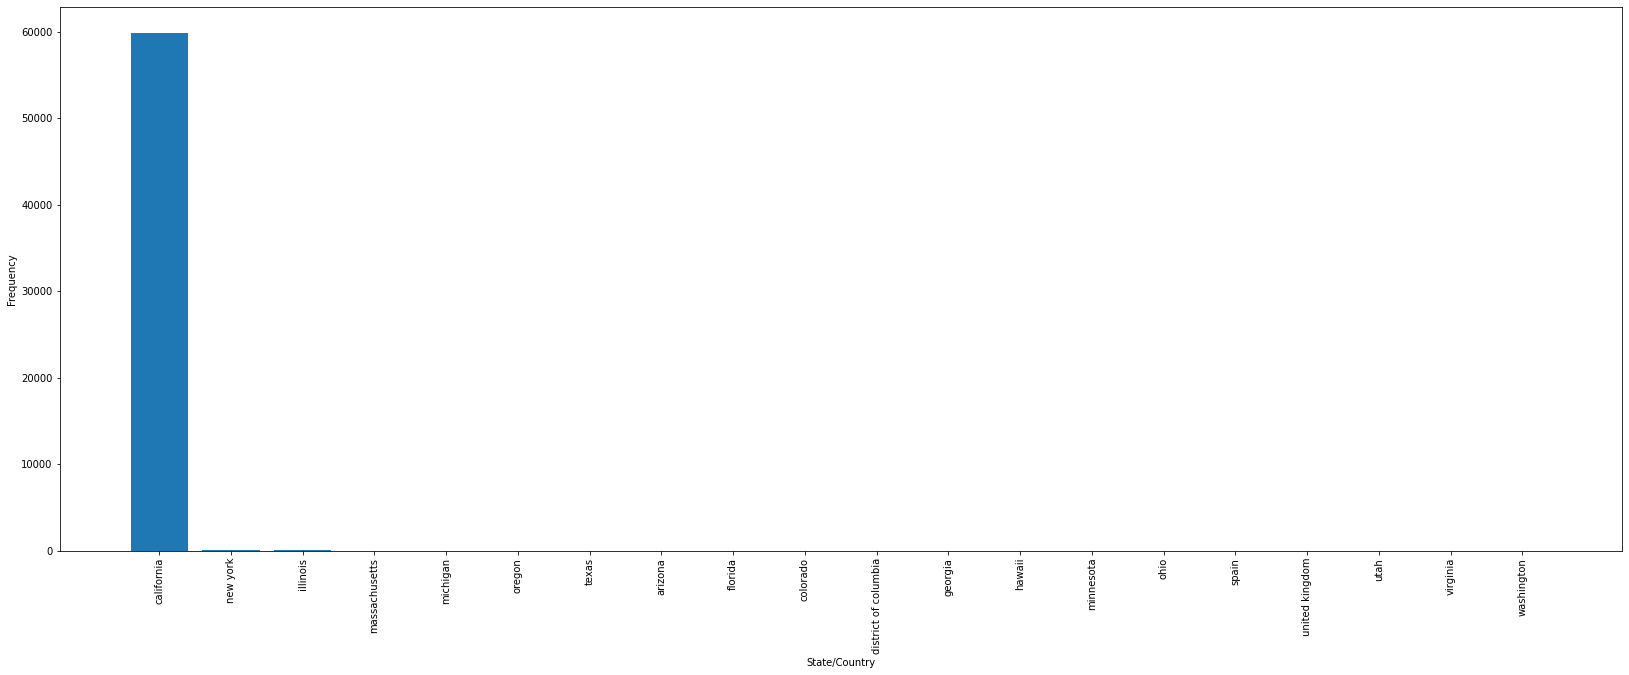

In [ ]:
locations,values = zip(*sorted_sum_list)
plt.figure(figsize=(28, 10))
plt.xlabel('State/Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(locations,values)

#### `ethnicity`

Eliminamos "other" por la misma razón que con los idiomas.

In [ ]:
ethnicities_lists = df.ethnicity.apply(lambda x: x.split(", ") if type(x) == str and "other" not in x else [])
ethnicities_df = pd.DataFrame(mlb.fit_transform(ethnicities_lists), columns=mlb.classes_, index=ethnicities_lists.index)
sum_dict = ethnicities_df.sum().to_dict()
ethnicities_df

asian  black  hispanic / latin  ...  native american  pacific islander  white
0          1      0                 0  ...                0                 0      1
1          0      0                 0  ...                0                 0      1
2          0      0                 0  ...                0                 0      0
3          0      0                 0  ...                0                 0      1
4          0      0                 0  ...                0                 0      0
...      ...    ...               ...  ...              ...               ...    ...
59939      0      0                 0  ...                0                 0      0
59940      0      0                 0  ...                0                 0      0
59941      1      0                 0  ...                0                 0      0
59942      1      1                 0  ...                0                 0      0
59943      0      0                 0  ...                0                 0      1

[59944 rows x 8 columns]

In [ ]:
sum_dict

{'asian': 7831,
 'black': 2937,
 'hispanic / latin': 4880,
 'indian': 1290,
 'middle eastern': 778,
 'native american': 960,
 'pacific islander': 1274,
 'white': 36644}

<BarContainer object of 8 artists>

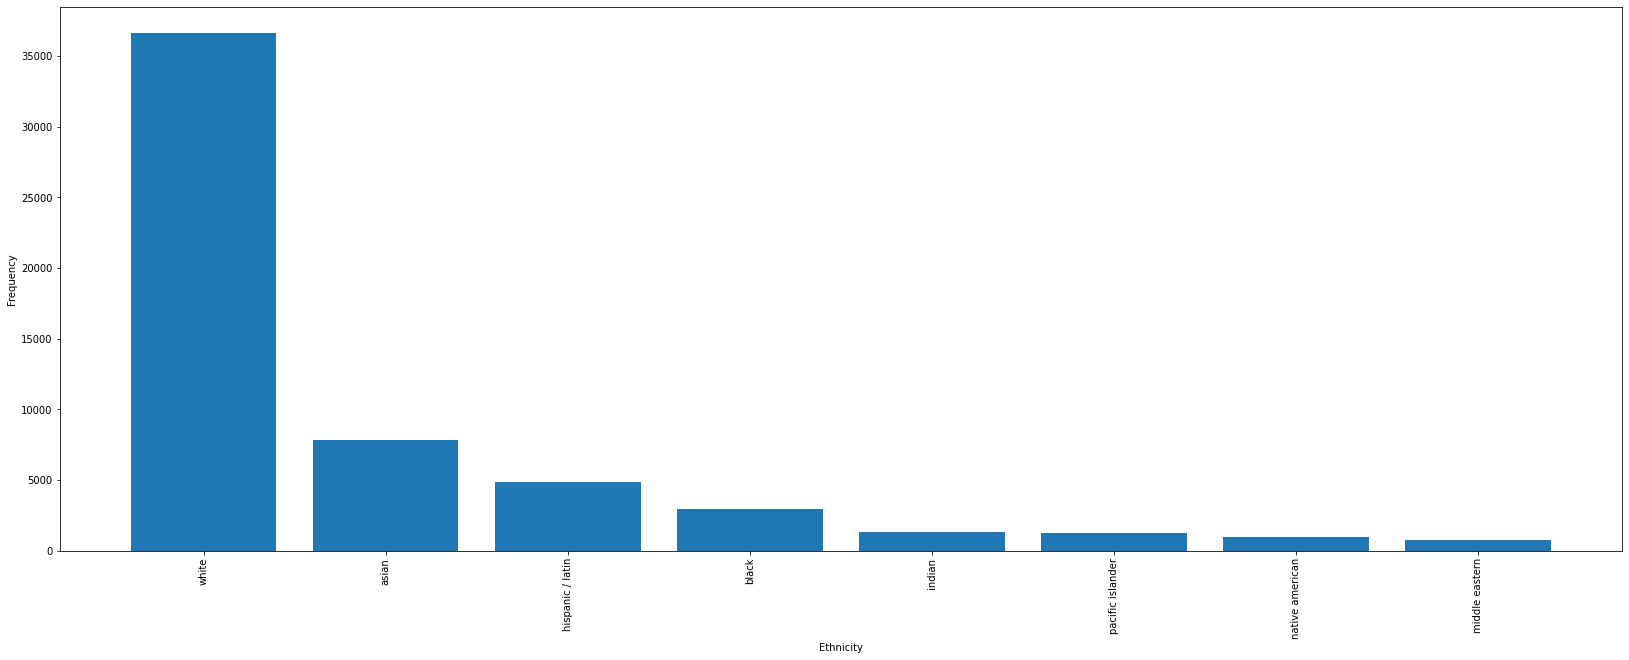

In [ ]:
sorted_sum_list = sorted({key:value for key,value in sum_dict.items()}.items(), key=lambda x: x[1], reverse=True)
ethnicities,values = zip(*sorted_sum_list)
plt.figure(figsize=(28, 10))
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(ethnicities,values)

#### `diet`

In [ ]:
df.diet.fillna(value="anything", inplace=True)
diet_lists = df.diet.apply(lambda x: ["any food"] if type(x) == str and ("anything" in x or 'other' in x) else [x])
diet_df = pd.DataFrame(mlb.fit_transform(diet_lists), columns=mlb.classes_, index=diet_lists.index)
diet_df

any food  halal  kosher  ...  strictly vegetarian  vegan  vegetarian
0             1      0       0  ...                    0      0           0
1             1      0       0  ...                    0      0           0
2             1      0       0  ...                    0      0           0
3             0      0       0  ...                    0      0           1
4             1      0       0  ...                    0      0           0
...         ...    ...     ...  ...                  ...    ...         ...
59939         1      0       0  ...                    0      0           0
59940         1      0       0  ...                    0      0           0
59941         1      0       0  ...                    0      0           0
59942         1      0       0  ...                    0      0           0
59943         1      0       0  ...                    0      0           0

[59944 rows x 13 columns]

#### One-Hot Encoder

In [ ]:
df_encoded = df.iloc[:,:-10]

for column in ["marital_status","sex","orientation","body_type","drinks","drugs","education","job","pets","religion","sign","smokes"]:
  df_encoded = pd.concat([df_encoded, pd.get_dummies(df[column], prefix=column)], axis=1)
  df_encoded.drop([column], axis=1, inplace=True)

for ohe_df in [languages_df, ethnicities_df, latitude_longitude_df, offspring_df, diet_df]:
  df_encoded = df_encoded.join(ohe_df)

df_encoded.drop(columns=['ethnicity', 'location', 'offspring', 'speaks', 'last_online', 'diet', 'marital_status_unknown'], inplace=True)

Chequeamos los resultados:

In [ ]:
print(any("unknown" in w for w in list(df_encoded.columns)))
print([w for w in list(df_encoded.columns) if "unknown" in w ])

print(any("other" in w for w in list(df_encoded.columns)))
print([w for w in list(df_encoded.columns) if "other" in w ])

print(any("anything" in w for w in list(df_encoded.columns)))
print([w for w in list(df_encoded.columns) if "anything" in w ])

False
[]
True
['religion_other', 'religion_other and laughing about it', 'religion_other and somewhat serious about it', 'religion_other and very serious about it', 'religion_other but not too serious about it']
False
[]


In [ ]:
df_encoded

index  age  height  ...  strictly vegetarian  vegan  vegetarian
0          0   22    75.0  ...                    0      0           0
1          1   35    70.0  ...                    0      0           0
2          2   38    68.0  ...                    0      0           0
3          3   23    71.0  ...                    0      0           1
4          4   29    66.0  ...                    0      0           0
...      ...  ...     ...  ...                  ...    ...         ...
59939  59941   59    62.0  ...                    0      0           0
59940  59942   24    72.0  ...                    0      0           0
59941  59943   42    71.0  ...                    0      0           0
59942  59944   27    73.0  ...                    0      0           0
59943  59945   39    68.0  ...                    0      0           0

[59944 rows x 443 columns]

In [ ]:
# Checks for null values:
print(df_encoded.isnull().sum().sum(), df_encoded.isna().sum().sum())
# print([number for number in df_encoded.isna().sum() if number != 0]) #To know the indices
# df_encoded.fillna(value=0, inplace=True) # If any NAs were found

0 0


##### Lemmatisation

In [ ]:
#We only care about the first letter to categorise
tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}
stop_words = set(stopwords.words('english'))

def lemmatise_text(text):
    if type(text) != str:
        return text
    tokens = word_tokenize(text.translate(str.maketrans('', '', string.punctuation)))
    filtered_sentence = [w for w in tokens if w not in stop_words]
    tags = [tag_dict.get(tag[1][0], wordnet.NOUN) for tag in nltk.pos_tag(filtered_sentence)]
    words_with_pos = list(zip(filtered_sentence, tags))
    return " ".join([lemmatiser.lemmatize(w, pos=pos) for w, pos in words_with_pos])

Para evitar la regeneración del resultado, exportamos a .csv en su momento, y así la ejecución es mucho más rápida.

In [ ]:
#lemmatised_essays = df.iloc[:,-10:].applymap(lemmatise_text) # Original
lemmatised_essays = pd.read_csv("lemmatised_essays.csv") # Read from .csv

In [ ]:
df.iloc[:,-10:].head()

essay0  ...                                             essay9
0  about me:  i would love to think that i was so...  ...  you want to be swept off your feet! you are ti...
1  i am a chef: this is what that means. 1. i am ...  ...                                               <NA>
2  i'm not ashamed of much, but writing public te...  ...  you are bright, open, intense, silly, ironic, ...
3          i work in a library and go to school. . .  ...                              you feel so inclined.
4  hey how's it going? currently vague on the pro...  ...                                               <NA>

[5 rows x 10 columns]

In [ ]:
lemmatised_essays.fillna(value='', inplace=True)
lemmatised_essays.head()

description  ...                                        looking_for
0  would love think kind intellectual either dumb...  ...  want sweep foot tired norm want catch coffee b...
1  chef mean 1 workaholic 2 love cook regardless ...  ...                                                   
2  im ashamed much write public text online date ...  ...  bright open intense silly ironic critical cari...
3                             work library go school  ...                                       feel incline
4  hey hows go currently vague profile know come ...  ...                                                   

[5 rows x 10 columns]

#####Tf-idf

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorizer = CountVectorizer(max_features=30, max_df=0.15)
tfidf_transformer = TfidfTransformer()

In [ ]:
X_transformed = []
top_words = []
for column in lemmatised_essays.columns:
  X = count_vectorizer.fit_transform(lemmatised_essays[column])
  top_words.extend(count_vectorizer.get_feature_names())
  X_transformed.append(tfidf_transformer.fit_transform(X.toarray()))

In [ ]:
print(top_words)
len(top_words)

['always', 'area', 'around', 'back', 'bay', 'city', 'come', 'day', 'family', 'feel', 'great', 'guy', 'laugh', 'learn', 'lot', 'meet', 'move', 'music', 'person', 'place', 'play', 'pretty', 'read', 'san', 'say', 'see', 'something', 'way', 'world', 'would', 'also', 'back', 'currently', 'day', 'enjoy', 'find', 'friend', 'good', 'ive', 'job', 'learn', 'like', 'live', 'look', 'lot', 'make', 'much', 'new', 'one', 'people', 'play', 'really', 'school', 'take', 'thing', 'travel', 'want', 'well', 'world', 'year', 'also', 'cook', 'dance', 'dont', 'find', 'friend', 'get', 'give', 'go', 'know', 'laugh', 'life', 'like', 'listen', 'love', 'new', 'one', 'play', 'pretty', 'really', 'say', 'take', 'talk', 'tell', 'think', 'time', 'try', 'well', 'work', 'write', 'also', 'always', 'ask', 'big', 'dont', 'first', 'get', 'good', 'hair', 'height', 'humor', 'ive', 'know', 'laugh', 'like', 'look', 'lot', 'make', 'notice', 'people', 'pretty', 'probably', 'really', 'say', 'sense', 'tall', 'tell', 'thing', 'think',

300

In [ ]:
X_transformed_list = [X_transformed[i].toarray() for i in range(10)]
np.array(X_transformed_list).shape

(10, 59944, 30)

In [ ]:
# Las 30 palabras más interesantes de cada essay 
# Cambiar el índice para otros essays
print(X_transformed[0].toarray())

[[0.         0.         0.         ... 0.52013968 0.         0.48720566]
 [0.48650479 0.         0.51091058 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.3230442  0.32857231 0.        ]
 ...
 [0.         0.37661097 0.         ... 0.         0.         0.34850564]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Juntar los 30 valores de las 10 columnas en un array de 300 valores,                      fila por fila
tfidf_essays = [np.array([X_transformed_list[i][j] for i in range(10)]).flatten() for j in range(len(lemmatised_essays))]

In [ ]:
df_tfidf_essays = pd.DataFrame(tfidf_essays, columns=top_words)
df_tfidf_essays

always      area    around  back  ...  thing  think  time  would
0      0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
1      0.486505  0.000000  0.510911   0.0  ...    0.0    0.0   0.0    0.0
2      0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
3      0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
4      0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
...         ...       ...       ...   ...  ...    ...    ...   ...    ...
59939  0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
59940  0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
59941  0.000000  0.376611  0.000000   0.0  ...    0.0    0.0   0.0    0.0
59942  0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0
59943  0.000000  0.000000  0.000000   0.0  ...    0.0    0.0   0.0    0.0

[59944 rows x 300 columns]

In [ ]:
# Testing if the processing worked 
"around" in df["description"][1]

True

In [ ]:
print(len(df_tfidf_essays))
print(len(df_encoded))

59944
59944


In [ ]:
df_encoded.describe()

index           age  ...         vegan    vegetarian
count  59944.000000  59944.000000  ...  59944.000000  59944.000000
mean   29973.035650     32.337715  ...      0.002269      0.011127
std    17304.978748      9.442423  ...      0.047578      0.104897
min        0.000000     18.000000  ...      0.000000      0.000000
25%    14986.750000     26.000000  ...      0.000000      0.000000
50%    29973.500000     30.000000  ...      0.000000      0.000000
75%    44959.250000     37.000000  ...      0.000000      0.000000
max    59945.000000     69.000000  ...      1.000000      1.000000

[8 rows x 443 columns]

Optamos por aportar un número de columnas de las essays que supusiese un porcentaje significativo de las columnas totales puesto que es una de las características que diferencian a OkCupid del resto de aplicaciones.

In [ ]:
df_complete = pd.concat([df_encoded,df_tfidf_essays], axis = 'columns').drop(columns="index")
df_complete

age  height  income  marital_status_available  ...  thing  think  time  would
0       22    75.0      -1                         0  ...    0.0    0.0   0.0    0.0
1       35    70.0   80000                         0  ...    0.0    0.0   0.0    0.0
2       38    68.0      -1                         1  ...    0.0    0.0   0.0    0.0
3       23    71.0   20000                         0  ...    0.0    0.0   0.0    0.0
4       29    66.0      -1                         0  ...    0.0    0.0   0.0    0.0
...    ...     ...     ...                       ...  ...    ...    ...   ...    ...
59939   59    62.0      -1                         0  ...    0.0    0.0   0.0    0.0
59940   24    72.0      -1                         0  ...    0.0    0.0   0.0    0.0
59941   42    71.0  100000                         0  ...    0.0    0.0   0.0    0.0
59942   27    73.0      -1                         0  ...    0.0    0.0   0.0    0.0
59943   39    68.0      -1                         0  ...    0.0    0.0   0.0    0.0

[59944 rows x 742 columns]

#### UMAP

In [ ]:
pip install umap-learn

**K PROTOTYPES**

Hemos usado la técnica K prototypes, que trabaja los datos categóricos de una forma algo diferente a un OHE común.

Debido a que en el Colab no funciona la técnica de reducción UMAP, adjuntamos el código y las capturas para que se vean los resultados

In [ ]:
from kmodes.kprototypes import KPrototypes
def get_categorical_weight(full_data):
  categorical = full_data.select_dtypes(include='object')
  categorical = pd.get_dummies(categorical)
  categorical.drop(columns=['religion_other','sign_'],inplace=True)

  #Percentage of columns which are categorical is used as weight parameter in embeddings later
  categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]
  return categorical, categorical_weight

In [ ]:
def get_umap(numerical,categorical):
  #Embedding numerical & categorical
  fit1 = umap.UMAP(metric='l2').fit(numerical)
  fit2 = umap.UMAP(metric='dice').fit(categorical[0])

  #Augmenting the numerical embedding with categorical
  intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical[1])
  intersection = umap.umap_.reset_local_connectivity(intersection)
  embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                  fit1._initial_alpha, fit1._a, fit1._b, 
                                                  fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                  200, 'random', np.random, fit1.metric, 
                                                  fit1._metric_kwds, False)
  return embedding

In [ ]:
# Returns indexes of categorical columns
def get_categorical_index(df):
    categoricals = []
    for i,column in enumerate(df.columns):
        if df[column].dtype == 'object':
            categoricals.append(i)
    return categoricals

In [ ]:
def umap_data_kprototypes(df, num_clusters):
    kprot_data = df.copy()

    #Pre-processing
    for c in kprot_data.select_dtypes(exclude='object').columns:
        pt = PowerTransformer()
        kprot_data[c] = pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

    categorical_columns = get_categorical_index(kprot_data)
    kprot_data = kprot_data.fillna('')
    
    #Actual clustering
    kproto = KPrototypes(n_clusters= num_clusters, init='Cao', n_jobs = 4)
    clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

    #Prints the count of each cluster group
    print(pd.Series(clusters).value_counts())
    
    embedding = get_umap(get_numerical(df),get_categorical_weight(df))
    
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.scatter(embedding[:, 0], embedding[:, 1],
              c=clusters, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('tab20c', num_clusters))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar();

In [ ]:
df_gay_female['sign'] = df_gay_female['sign'].fillna('')
umap_data_kprototypes(df_gay_female, 3)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


0    1387
2    1134
1    1043
dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


NameError: ignored